# 🏘 Finding Drivers of Zestimate Errors
Project and Report Created By: Ray Zapata<br>
June 28, 2021<br><br>

<img src='https://raw.githubusercontent.com/ray-zapata/project_clustering_zillow/main/assets/header.png'>
<p style="text-align: center;">
    [<a href='#%F0%9F%92%A0-Data-Acquisition'>acquire</a>]
    [<a href='#%F0%9F%92%A0-Data-Preparation'>prepare</a>]
    [<a href='#%F0%9F%92%A0-Data-Exploration'>explore</a>]
    [<a href='#%F0%9F%92%A0-Modeling-and-Evaluation'>models</a>]
    [<a href='#%F0%9F%92%A0-Final-Test'>test</a>]
    [<a href='#%F0%9F%92%A0-Report-Summary'>summary</a>]
</p>

## 💠 Project Overview

This final report contains a high-level view into the project process and results, as well as our recommended actions and next phases. For additional insight into the [exploration](https://nbviewer.jupyter.org/github/ray-zapata/project_clustering_zillow/blob/main/exploration.ipynb) and [modeling](https://nbviewer.jupyter.org/github/ray-zapata/project_clustering_zillow/blob/main/modeling.ipynb) phase, the two notebooks linked here contain a more in-depth explanation of the process.

### Goals

The primary focus of the project was to set out and discover potential drivers of the `log_error` of the Zillow® Zestimate for *single-unit properties* sold during $2017$. In this context, `log_error` is equal to $log(Zestimate) - log(SalePrice)$. After sufficient exploration, these potential drivers would be used as features in predicting the `log_error` with linear regression algorithms. In attempt to find these drivers, clustering methodologies were used to explore any meaningful groups that are present in the data.

### Process

Upon successful acquisition of the data from the Codeup `zillow` database, it was then transformed into a series of DataFrames which could be used in exploration and model creation. From the initial SQL query, $77,579$ property oberservations were obtained. This was then filtered to remove any observations that were duplicates of properties sold more than once to retain only the most recent transaction in $2017$. Firstly, any variables that was not sufficiently defined, were mislabeled, or were redundant to other columns were dropped. This data was further pared down by removing columns which were missing $25\%$ or more values. Using $\pm$$IQR * 1.5$ as upper- and lower-bounds, outliers in the data were removed. This left $61,625$ remaining observations, $\approx79\%$ of the initial observations. Lastly, the data was separated into splits of $60\% / 20\% / 20\%$ for the `train`, `validate`, and `test` data sets. From there, any continuous variables were scaled for use clustering and regression modeling before the top performing model was finally put to test on the out-of-sample `test` data.

### Initial Thoughts

It was initially suspected that a significant factor in `log_error` deviating from zero would be due to the under- or over-estimation of property value based on property's physical location. All observations carried through preparation had several methods for location testing, including census precincts and latitudinal & longitudinal geographic coordinates. This would be the initial hypothesis, that property location, when appropriately segmented into geographic of sociological divisions, would have a strong correlation to `log_error`.

**🔮 Target Insights**

Assuming the "common logarithm" with base 10, the mean "true" error of `log_error` in the $60\%$ `train` data set is $\approx1.43$ USD. This seems to be an unlikely case, especially considering the mean tax appraised value in the same data set is $344,010$ USD. Given that the median Zestimate was off by [over $14\%$ in $2016$](https://www.bloomberg.com/news/articles/2021-02-25/zillow-s-price-estimates-are-now-cash-offers-in-homebuying-push), there is some hidden math involved in the calculations that makes any transformation of the target for additional insight unobtainable at this time.

### Findings and Next Phase

Using clustering and linear regression machine learning methodologies, it was discovered there may be some potential standing to the initial hypothesis. Several clusters were formed, two of which utilized location-based features, and these clusters would be recommended by feature selection algorithms for model predictions. While not a significant increase, the best performing model on out-of-sample data was carried into final testing on the $20\%$ `test` data set where it just barely edged out the root mean squared error of the baseline created using the mean of `log_error`. Given the shape of the plotted residuals and the abysmally low percentage change in RMSE from model to baseline mean, it is unlikely this produced any insights of value. There is much more work to be done in understanding the question of what is driving the Zestimate errors.

Due to the scope and time frame of this project, it was not attempted to go into a more exhaustive exploration of location features in finding the drivers sought. With additional time and resources, it is desirable to attempt to use either paid or open-source geocoding tools and methodologies in obtaining more precise locations of properties and the neighborhoods, zip codes, and street blocks in which the exist. In future ventures regarding drivers of `logerror`, it would also be desirable to test for finding drivers which are more likely to result in specifically either over or under estimation of property value.

**⏯  Initialize Notebook**

In [1]:
# import standard libraries
import pandas as pd
import numpy as np

# import visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# import clustering and metric tools
from sklearn.cluster import KMeans
import scipy.stats as stats

# import model tools
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, TweedieRegressor

# import created scripts
import acquire, prepare, explore, wrangle, model

# cosmetic imports and settings
import warnings
warnings.filterwarnings("ignore")
from matplotlib.pyplot import style
style.use('~/.matplotlib/gruvbox.mplstyle')
from end import end

## 💠 Data Acquisition
---
Connecting to the Codeup database, the data will be acquired using `pd.read_sql` and a custom made function that will cache the data in a CSV if one does not already exist. It will then be checked for null values within the columns and summarized prior to preparation.

In [2]:
# create variable to hold SQL query
query = '''
    SELECT *, properties_2017.id AS property_id
    FROM properties_2017
    INNER JOIN predictions_2017
        USING(parcelid)
    LEFT OUTER JOIN airconditioningtype
        USING(airconditioningtypeid)
    LEFT OUTER JOIN architecturalstyletype
        USING(architecturalstyletypeid)
    LEFT OUTER JOIN buildingclasstype
        USING(buildingclasstypeid)
    LEFT OUTER JOIN heatingorsystemtype
        USING(heatingorsystemtypeid)
    LEFT OUTER JOIN propertylandusetype
        USING(propertylandusetypeid)
    LEFT OUTER JOIN storytype
        USING(storytypeid)
    LEFT OUTER JOIN typeconstructiontype
        USING(typeconstructiontypeid)
    LEFT OUTER JOIN unique_properties
        USING(parcelid)
    WHERE
        transactiondate LIKE '2017%%' AND
        latitude IS NOT NULL AND
        longitude IS NOT NULL;'''

In [3]:
# read in initial DataFrame
df = acquire.get_sql(query, 'zillow')

In [4]:
# create list of single unit propertylandusedesc
single_prop_types = ['Single Family Residential', 'Condominium', 'Mobile Home',
                     'Manufactured, Modular, Prefabricated Homes', 'Townhouse']
# filter for most-likely single unit properties
df = df[df.propertylandusedesc.isin(single_prop_types)]
df = df[(df.bedroomcnt > 0) & (df.bedroomcnt <= 10)]
df = df[(df.bathroomcnt > 0) & (df.bathroomcnt <= 10)]

In [5]:
# view summary of missing values from each column
# display cols missing at least than 15%
nulls = acquire.cols_with_null_rows(df)
nulls[nulls.num_rows_missing.astype(int) > 11500]

,num_rows_missing,pct_rows_missing
,,
airconditioningdesc,48526,67.93%
airconditioningtypeid,48526,67.93%
architecturalstyledesc,71228,99.71%
architecturalstyletypeid,71228,99.71%
basementsqft,71388,99.93%
buildingclassdesc,71435,100.00%
buildingclasstypeid,71435,100.00%
buildingqualitytypeid,26564,37.19%
decktypeid,70846,99.18%


### ❗ Acquisition Notes

Obtaining the data and filtering it for only single-unit properties sold during 2017 results in 77579 observations being read into the initial DataFrame. Of the 70 columns which make up the data, 39 are missing $35\%$ or more values. It's possible that some of the null values are the result of not including all the zero-counts for certain items, such as `poolcnt` and `garagecarcnt`. With the data present, however, it is not possible to say with certainty that is the case. Most of these columns will need to be dropped in order to maximize the number of observations that make it through to modeling.

[[return to top](#%F0%9F%8F%98-Finding-Drivers-of-Zestimate-Errors)]

## 💠 Data Preparation
---
Now that the data has been obtained, it is time to prepare it a manner to best perform exploration and modeling in later phases. Redundant columns were dropped outright, along with columns that did not have sufficient clarity on what the values contained represented. Then all columns missing more than $25\%$ of total observations were dropped, and rows which did not contain values for $50\%$ of those columns were removed. Finally, rows with values that were missing for columns that imputing was not sound were dropped. The data was then run through a function that removed outliers for continuous variables using $\pm$$IQR * 1.5$ to drop values above or below the upper- and lower-bounds.

In [6]:
df = wrangle.prep_zillow().drop(columns=['log_error', 'parcel_id', 'property_id'])

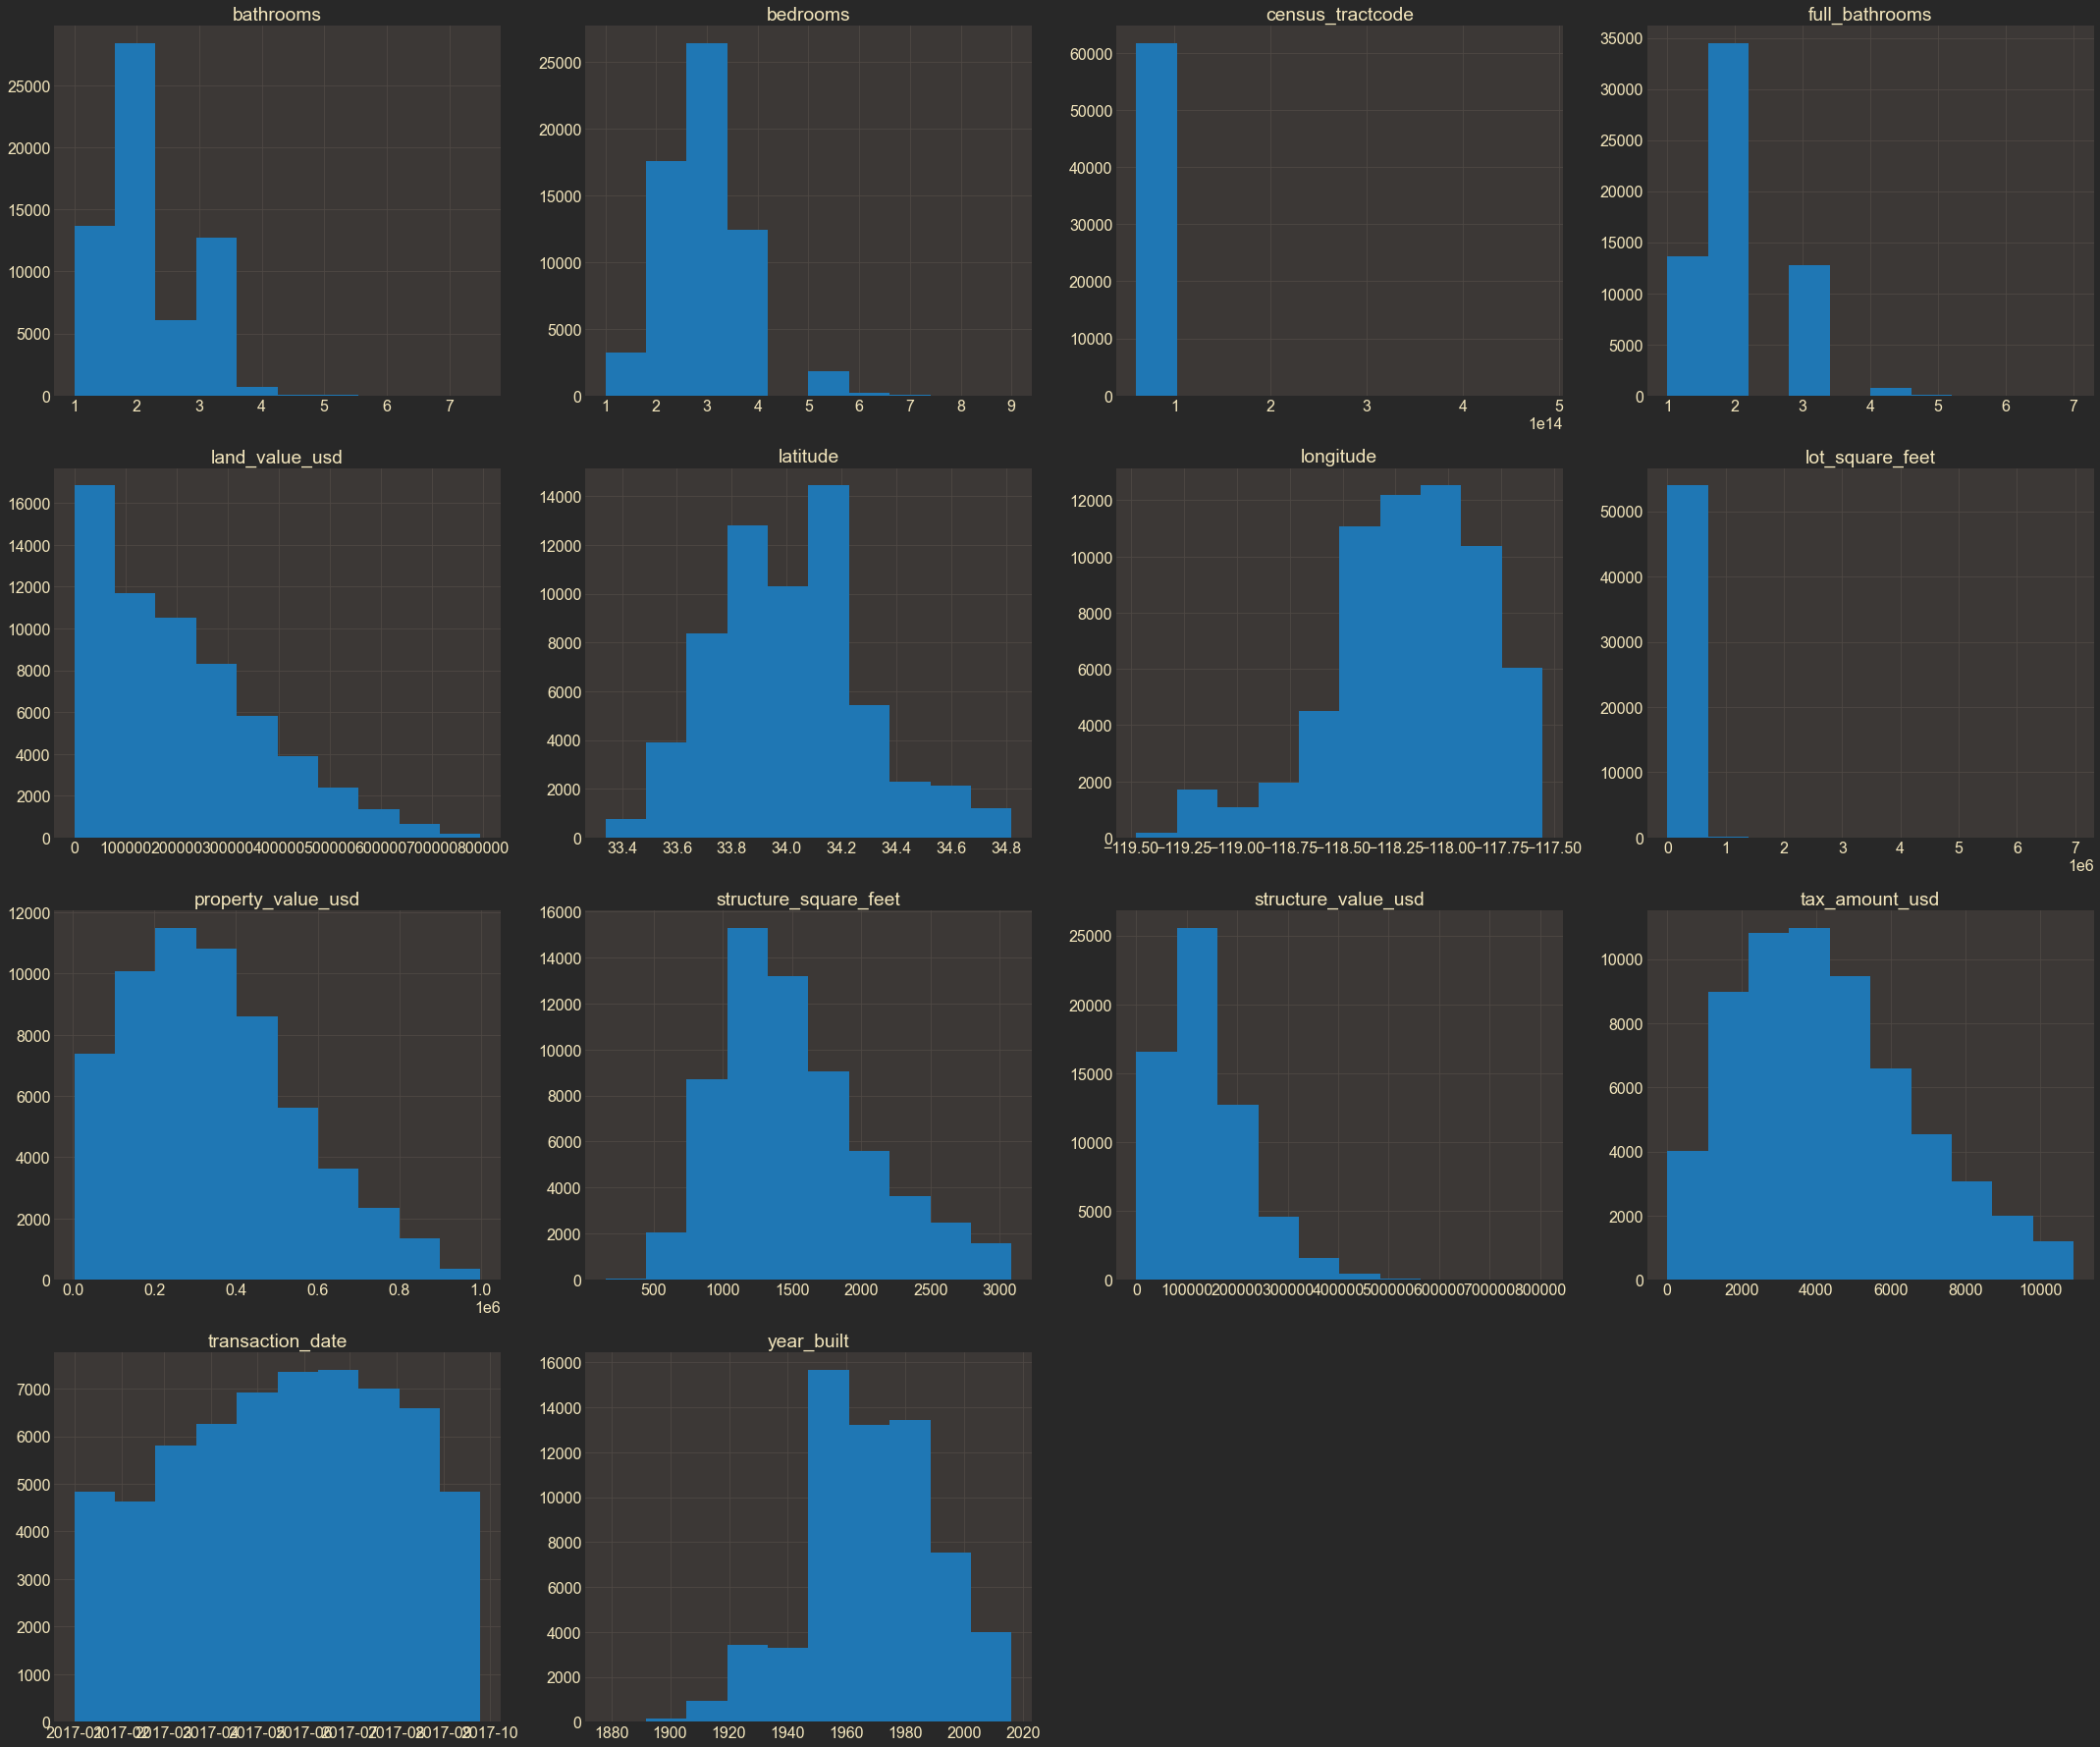

In [7]:
# visualize distributions after outlier removal
df.hist(figsize=(30,25))
plt.tight_layout()
plt.show()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61625 entries, 1 to 77578
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   bathrooms              61625 non-null  float64       
 1   bedrooms               61625 non-null  int64         
 2   census_tractcode       61625 non-null  float64       
 3   county                 61625 non-null  object        
 4   full_bathrooms         61625 non-null  float64       
 5   land_value_usd         61625 non-null  float64       
 6   latitude               61625 non-null  float64       
 7   longitude              61625 non-null  float64       
 8   lot_square_feet        54180 non-null  float64       
 9   property_value_usd     61625 non-null  float64       
 10  structure_square_feet  61625 non-null  float64       
 11  structure_value_usd    61625 non-null  float64       
 12  tax_amount_usd         61625 non-null  float64       
 13  t

### ❗ Preparation Summary

Completing the data preparation, what remains is 61,625 observations with 15 columns of variables. All but one contain zero null-values, with lot_square_feet missing $\approx12\%$ of total. This will be imputed with the mean of all observations, and used with careful consideration in further phases. Several of these variables will be used to create new features to find additional insights in exploration.

**Create Features**:
- `acreage`: product of `lot_square_feet` and the conversion constant $0.00002295682$
- `age`: difference of the year $2017$ and the property `year_built`
- `bedrooms_per_sqft`: division of `bedrooms` by `structure_square_feet`
- `room_count`: sum of `bedrooms` and `bathrooms` on property
- `transaction_month`: extracted month from the `transaction_date`

[[return to top](#%F0%9F%8F%98-Finding-Drivers-of-Zestimate-Errors)]

## 💠 Data Exploration
---
Now that data preparation is complete, it can be obtained using a function that performs all of the steps taken to ready it for exploration. All exploration will occur on the $60\%$ `train` split, and attempts to glean any meaningful relationships  will be made. Using Pearson $r$ to find correlation coefficients, a heat map of variables to the target will be made to find any obvious material associations. For a more in-depth look into this and the preceding process, please see the `exploration.ipynb` notebook.

In [9]:
# acquire prepared data for exploration and later modeling
X_train, y_train, \
X_validate, y_validate, \
X_test, y_test = wrangle.wrangle_zillow()


*----------------------------------------*
|  ***   Data Preparation Summary   ***  |
*----------------------------------------*
|                                        |
|       Initial Observations: 77,579     |
|      Prepared Observations: 61,625     |
|          Null Loss Percent: 20.56%     |
|                                        |
|       X_train Observations: 36,975     |
|           Percent of Total: 48%        |
|               Percent of X: 60%        |
|                                        |
|    X_validate Observations: 12,325     |
|           Percent of Total: 16%        |
|               Percent of X: 20%        |
|                                        |
|        X_test Observations: 12,325     |
|           Percent of Total: 16%        |
|               Percent of X: 20%        |
|                                        |
*~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~*


In [10]:
# combine target to DataFrame for exploration
train = pd.concat((X_train, y_train.log_error), axis=1)

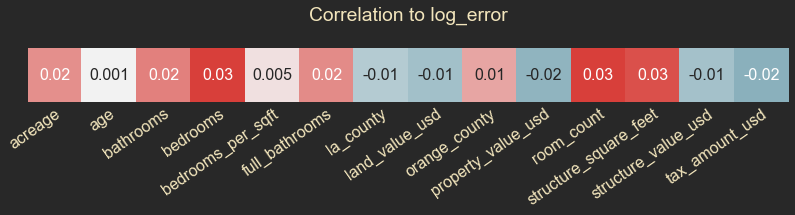

In [11]:
# create heatmap to find any obvious correlations to target
col_list = ['acreage', 'age', 'bathrooms', 'bedrooms',
            'bedrooms_per_sqft', 'full_bathrooms', 'la_county',
            'land_value_usd', 'orange_county', 'property_value_usd',
            'room_count', 'structure_square_feet', 'structure_value_usd',
            'tax_amount_usd', 'log_error']
explore.target_heat(train[col_list], 'log_error')

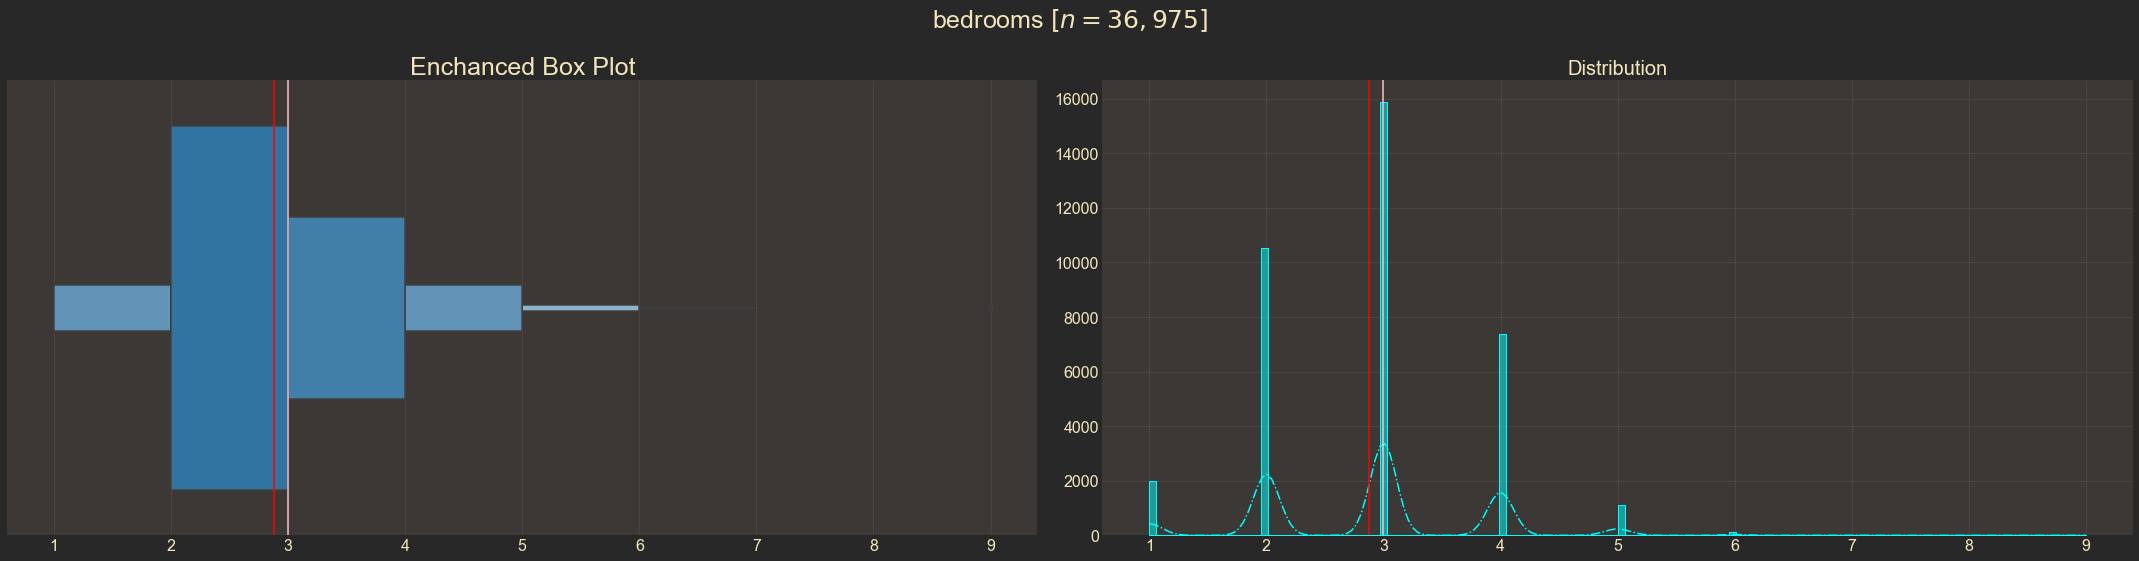

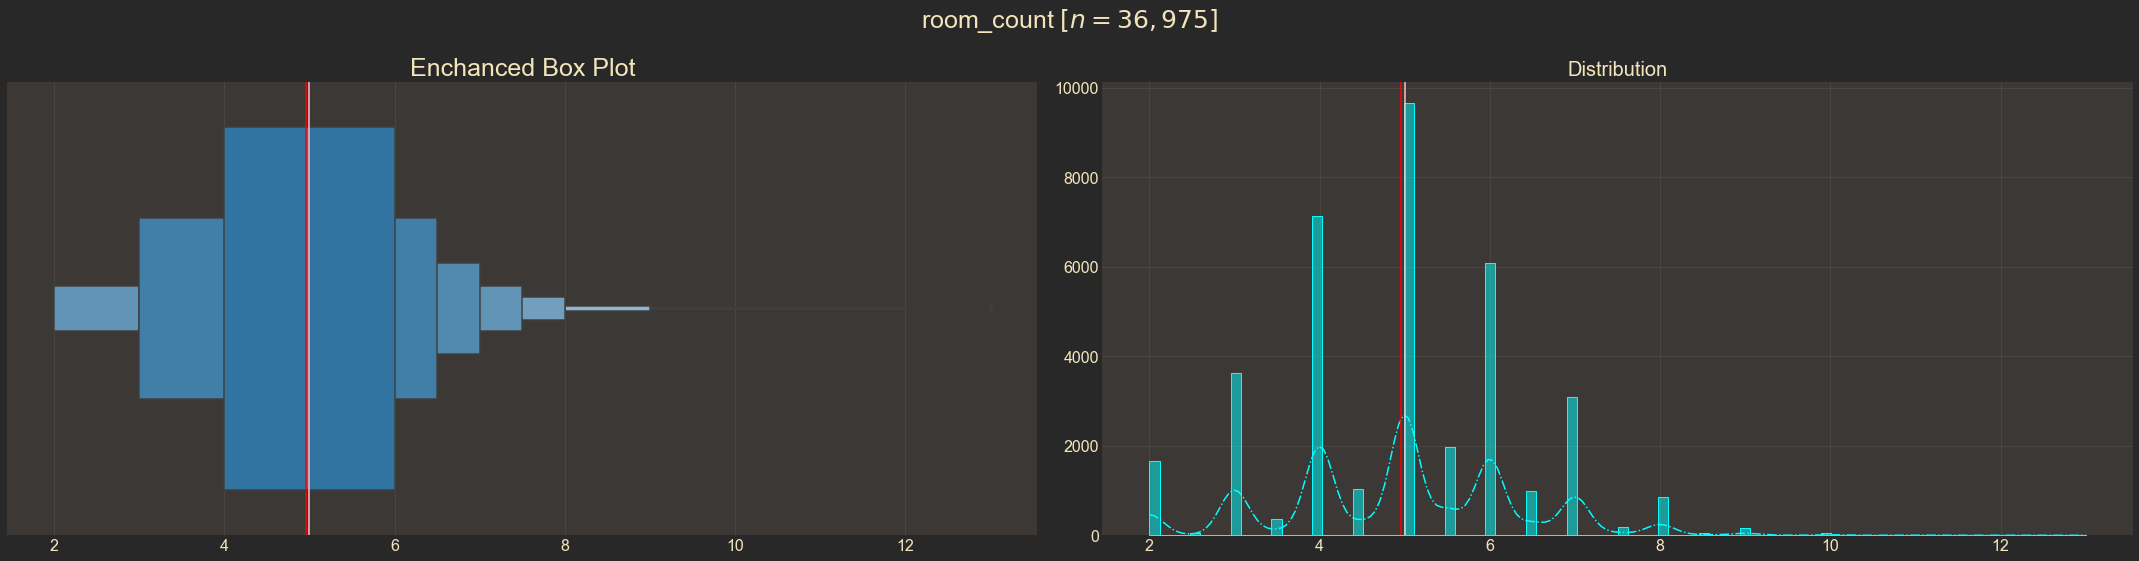

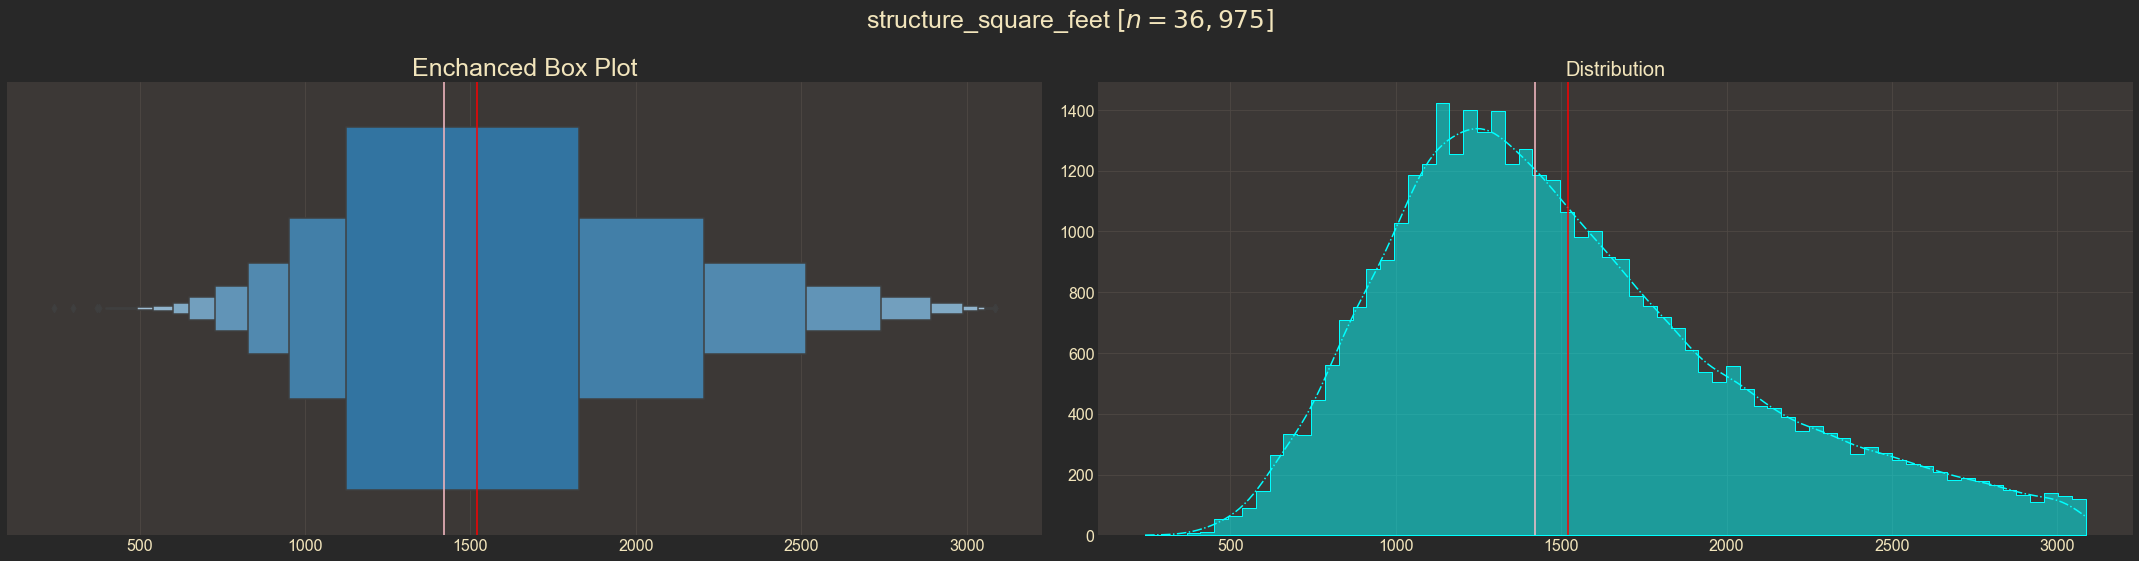

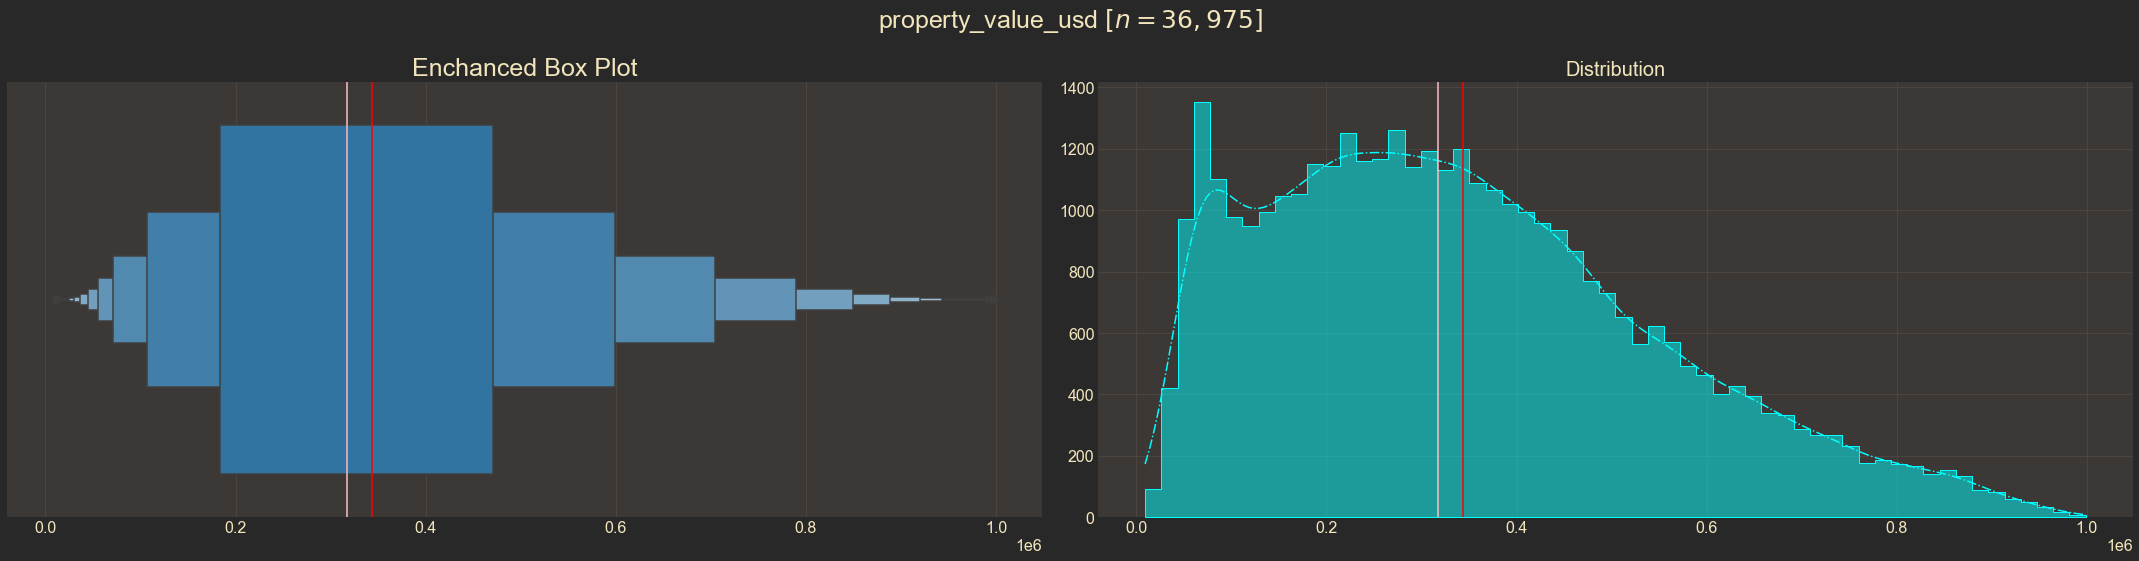

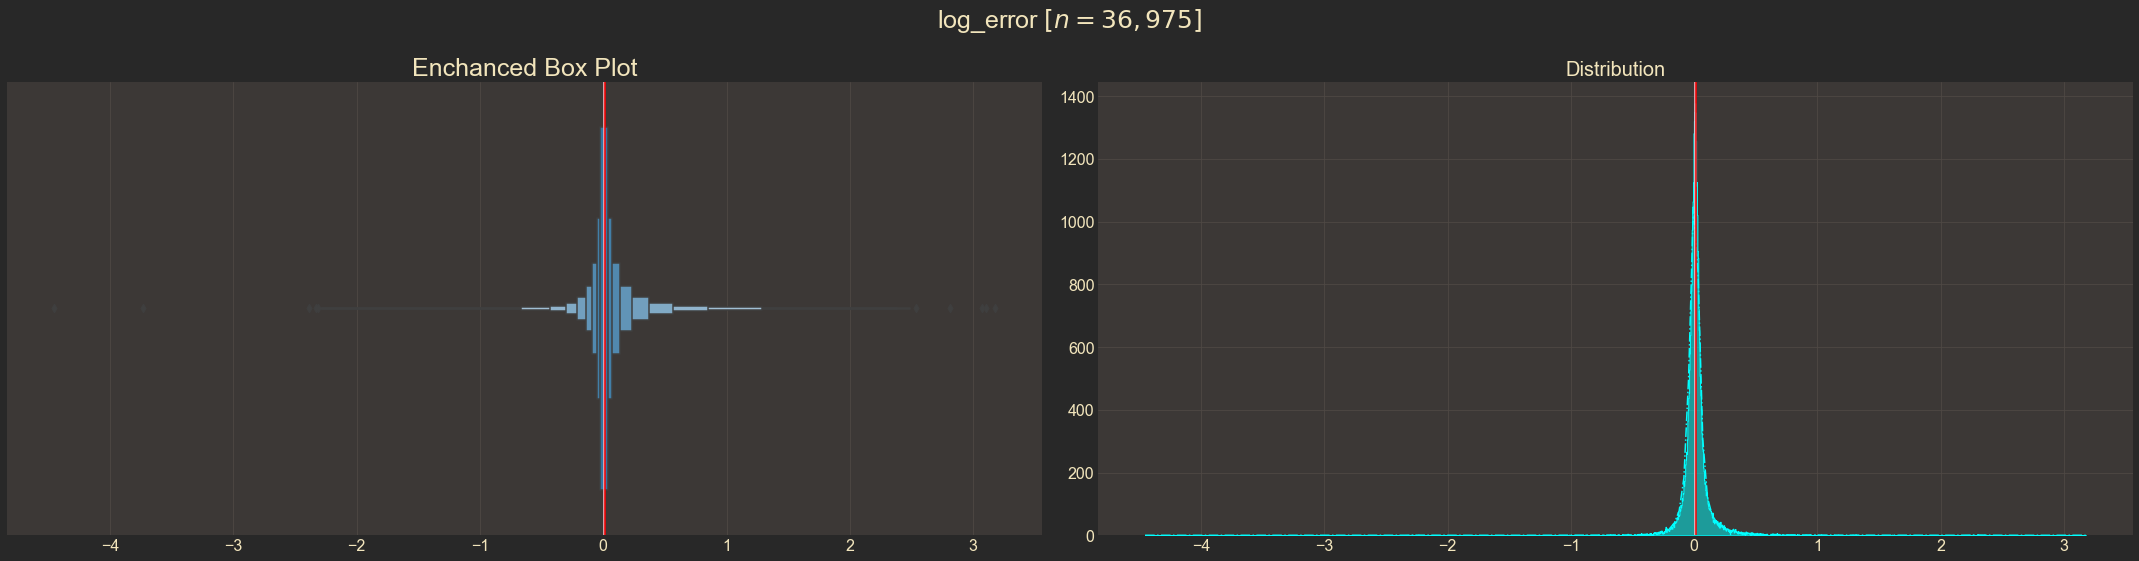

In [12]:
# look more closely at strongest correlations to log_error
explore.plot_univariate(train, 'bedrooms')
explore.plot_univariate(train, 'room_count')
explore.plot_univariate(train, 'structure_square_feet')
explore.plot_univariate(train, 'property_value_usd')
explore.plot_univariate(train, 'log_error')

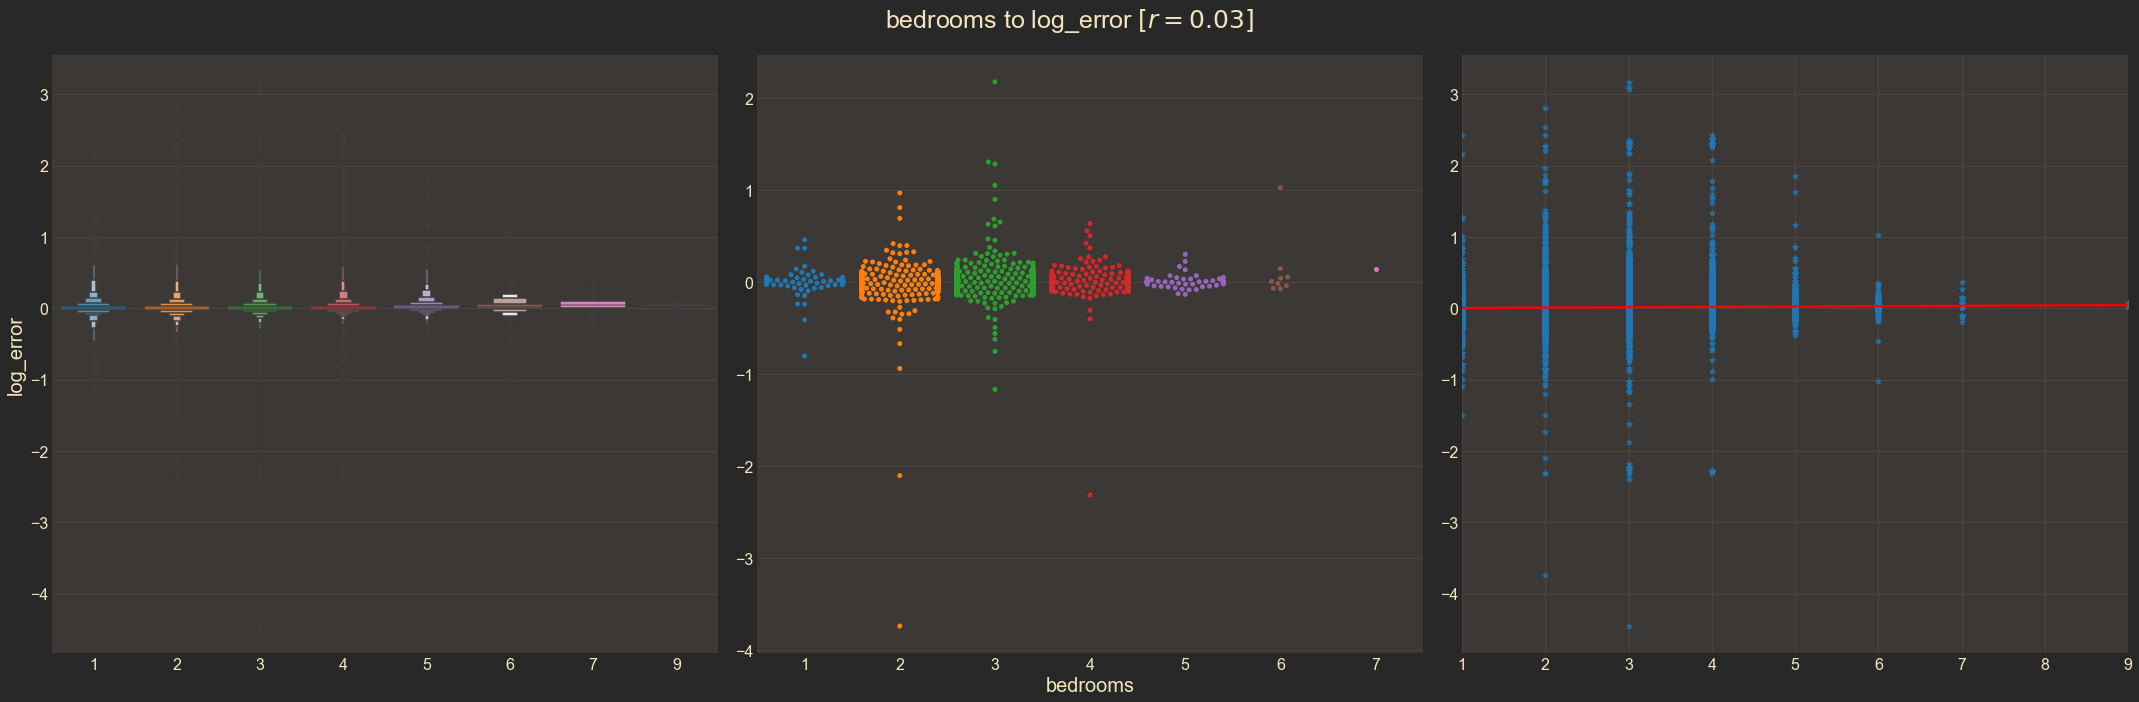

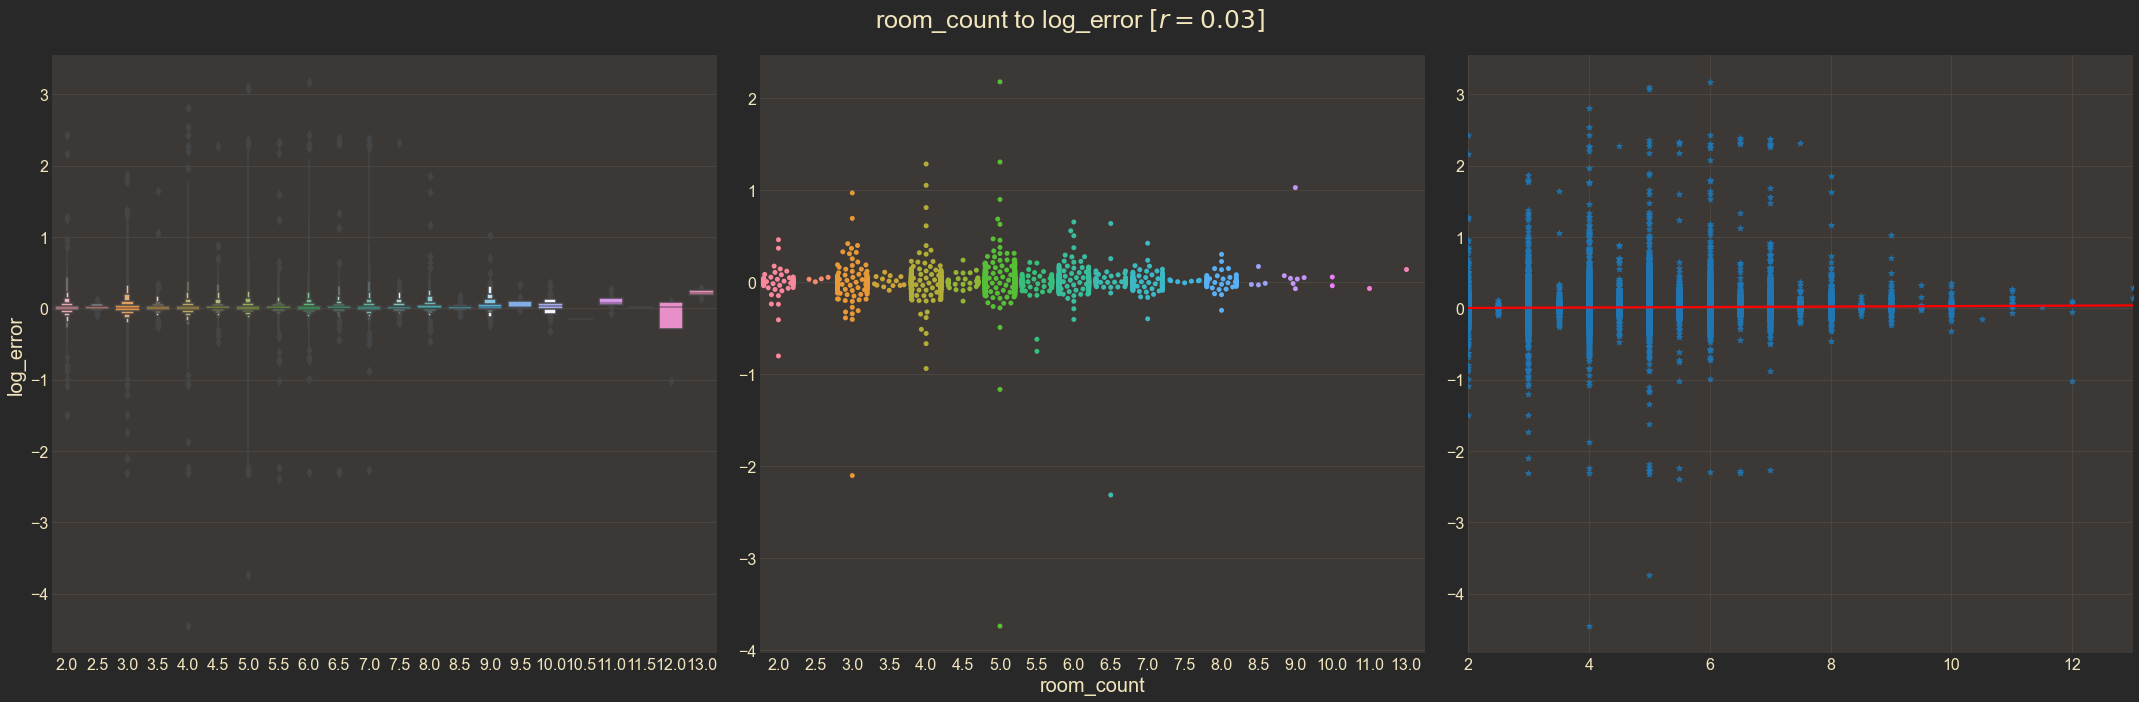

In [13]:
# plot relationship of categorical variables to target
explore.plot_discrete_to_continous(train, 'bedrooms', 'log_error')
explore.plot_discrete_to_continous(train, 'room_count', 'log_error')

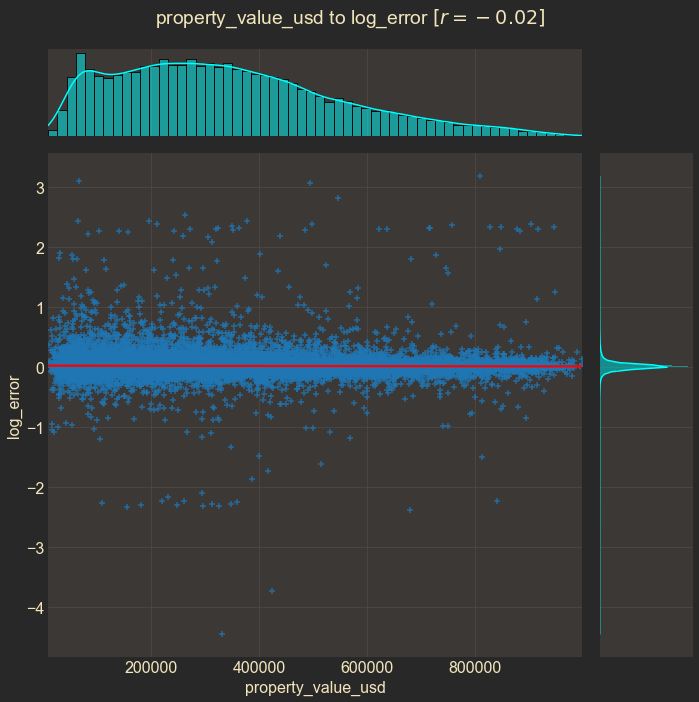

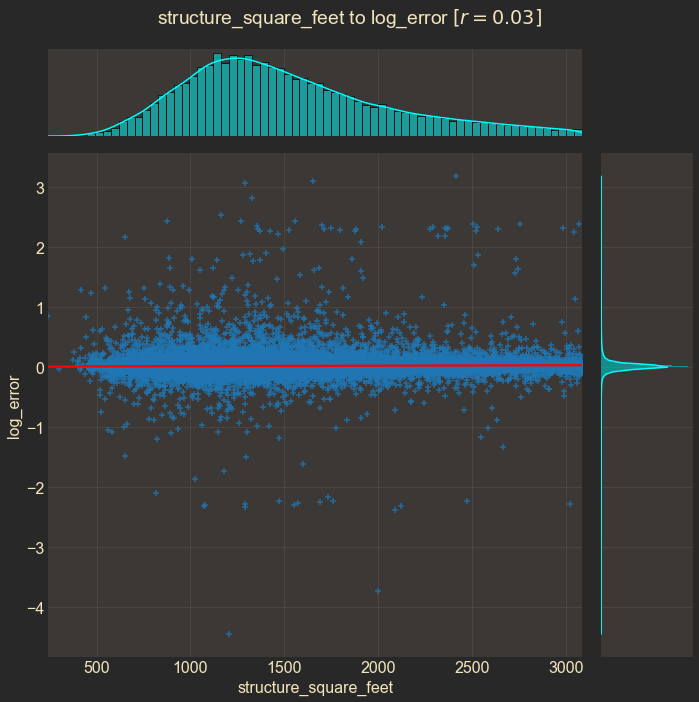

In [14]:
# plot relationship of continuous variables to target
explore.plot_joint(train, 'property_value_usd', 'log_error')
explore.plot_joint(train, 'structure_square_feet', 'log_error')

In [15]:
# perform statistical tests on strongest correlations according to heatmap
explore.corr_test(train, 'bedrooms', 'log_error')
explore.corr_test(train, 'structure_square_feet', 'log_error')
explore.corr_test(train, 'property_value_usd', 'log_error')
explore.corr_test(train, 'tax_amount_usd', 'log_error')

   pearson r = 0.029
+--------------------+

        Due to p-value 1.9e-08 being less than our significance level of 0.05, we may reject the null hypothesis 
        that there is not a linear correlation between "bedrooms" and "log_error."
        
   pearson r = 0.026
+--------------------+

        Due to p-value 3.5e-07 being less than our significance level of 0.05, we may reject the null hypothesis 
        that there is not a linear correlation between "structure_square_feet" and "log_error."
        
   pearson r = -0.017
+--------------------+

        Due to p-value 0.0012 being less than our significance level of 0.05, we may reject the null hypothesis 
        that there is not a linear correlation between "property_value_usd" and "log_error."
        
   pearson r = -0.018
+--------------------+

        Due to p-value 0.0006 being less than our significance level of 0.05, we may reject the null hypothesis 
        that there is not a linear correlation between "tax_amoun

### ❗ Initial Takeaways

Despite being able to reject the null hypotheses, the strength of the correlations are nearly zero for the strongest two negative and two positive relationships. Looking at the regression line on the plots, it looks like an almost flat line. They may have a statistically evident relationship, but the strength of that relationship provides little insight and suggests any individual variable would be unlikely to be a strong driver.

### Exploration of Clusters

In this section, several clusters are created to try and discern potential groupings with significantly difference variances in `log_error` between those populations. The number of clusters was determined using the elbow plot method to find when change in inertia to $k$ has dropped relative to lower $k$ values. Using analysis of variance (ANOVA) test, those clusters that can reject the respective null hypothesis will be carried into potential model features.

#### `lat_long_clstr`

This cluster is a simple grouping of five clusters using `latitude` and `longitude`.

**Hypotheses and Significance Level**
- H$_0$: There is no significant difference in `log_error` between cluster groups for `latitude` and `longitude`.
- H$_a$: There is a  significant difference in `log_error` between cluster groups for `latitude` and `longitude`.
- $\alpha$: 0.05

In [16]:
# scale data for distance in kmeans
scaler = StandardScaler()
scaled = scaler.fit_transform(train[['latitude', 'longitude']])
explore_df = pd.DataFrame(scaled, columns=['latitude', 'longitude'], index=train.index)
# create clusters for exploring log_error relative to location
cluster_df, center_df, kmeans = explore.explore_clusters(explore_df, ['latitude', 'longitude'], k=5)

In [17]:
# set alpha for testing significance
alpha = 0.05
# create DataFrame of samples for ANOVA testing
samples = pd.concat((cluster_df, train.log_error), axis=1)
# Perform ANOVA one-way test for null hypotesis
F, p = stats.f_oneway(samples[samples.cluster == 0].log_error,
                      samples[samples.cluster == 1].log_error,
                      samples[samples.cluster == 2].log_error,
                      samples[samples.cluster == 3].log_error,
                      samples[samples.cluster == 4].log_error)
# print fail or succeed to reject and values returned
if p < alpha:
    state = '✓ May reject'
else:
    state = '𐄂 Fail to reject'
print(f'''
      Stats
+---------------+
|  F-stat: {F:.2f} |  {state}
| p-value: {p:.2f} |  the null hypothesis.
+---------------+
''')


      Stats
+---------------+
|  F-stat: 3.55 |  ✓ May reject
| p-value: 0.01 |  the null hypothesis.
+---------------+



#### `lot_rooms_clstr`

Using `acreage` and `room_count`, this two-dimensional cluster was again made into five groups per the below method.

**Hypotheses and Significance Level**
- H$_0$: There is no significant difference in `log_error` between cluster groups for `acreage` and `room_count`.
- H$_a$: There is a  significant difference in `log_error` between cluster groups for `acreage` and `room_count`.
- $\alpha$: 0.05

In [18]:
# scale data for distance in kmeans
scaler = StandardScaler()
scaled = scaler.fit_transform(train[['acreage', 'room_count']])
explore_df = pd.DataFrame(scaled, columns=['acreage', 'room_count'], index=train.index)
# create clusters for exploring log_error relative to location
cluster_df, center_df, kmeans = explore.explore_clusters(explore_df, ['acreage', 'room_count'], k=5)

In [19]:
# set alpha for testing significance
alpha = 0.05
# create DataFrame of samples for ANOVA testing
samples = pd.concat((cluster_df, train.log_error), axis=1)
# Perform ANOVA one-way test for null hypotesis
F, p = stats.f_oneway(samples[samples.cluster == 0].log_error,
                      samples[samples.cluster == 1].log_error,
                      samples[samples.cluster == 2].log_error,
                      samples[samples.cluster == 3].log_error,
                      samples[samples.cluster == 4].log_error)
# print fail or succeed to reject and values returned
if p < alpha:
    state = '✓ May reject'
else:
    state = '𐄂 Fail to reject'
print(f'''
      Stats
+---------------+
|  F-stat: {F:.2f} |  {state}
| p-value: {p:.2f} |  the null hypothesis.
+---------------+
''')


      Stats
+---------------+
|  F-stat: 11.49 |  ✓ May reject
| p-value: 0.00 |  the null hypothesis.
+---------------+



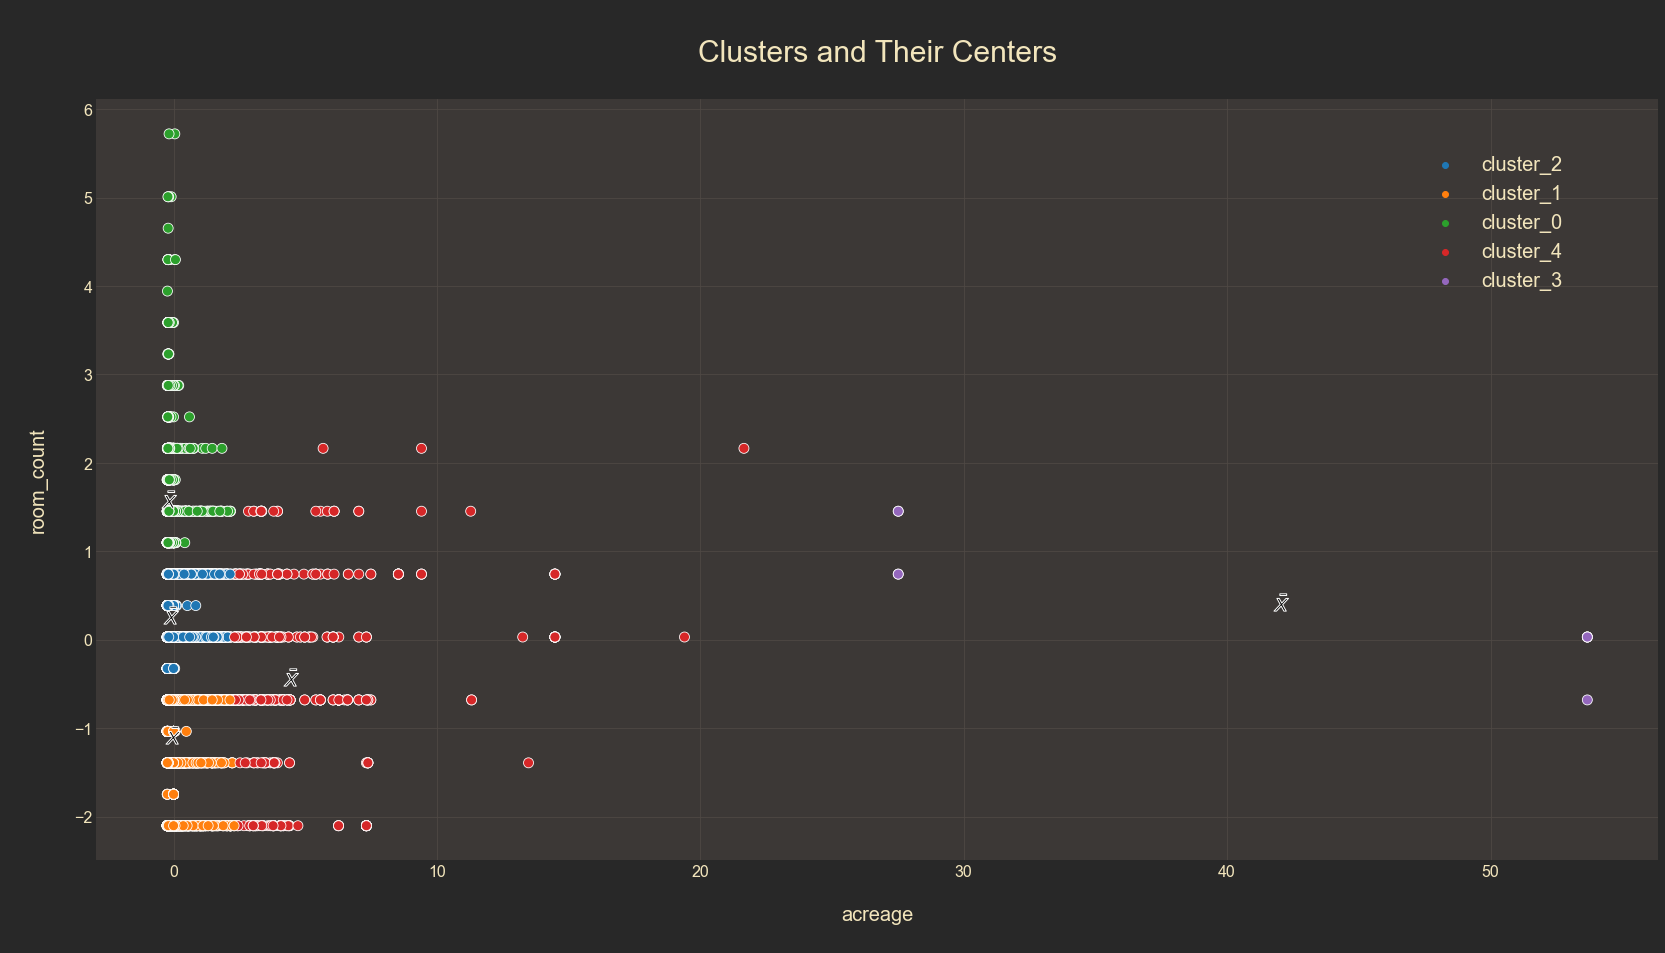

In [20]:
# create plot to view clusters for lot_rooms_clstr
explore.plot_clusters(cluster_df, center_df, 'acreage', 'room_count')

#### `bed_sqft_age_clstr`

Rather than lot size, this cluster of five is a functionally three-dimensional group with two of those dimensions flattened into `bedrooms_per_sqft` and using `age`.

**Hypotheses and Significance Level**
- H$_0$: There is no significant difference in `log_error` between cluster groups for `bedrooms_per_sqft` and `age`.
- H$_a$: There is a  significant difference in `log_error` between cluster groups for `bedrooms_per_sqft` and `age`.
- $\alpha$: 0.05

In [21]:
# scale data for distance in kmeans
scaler = StandardScaler()
scaled = scaler.fit_transform(train[['bedrooms_per_sqft', 'age']])
explore_df = pd.DataFrame(scaled, columns=['bedrooms_per_sqft', 'age'], index=train.index)
# create clusters for exploring log_error relative to location
cluster_df, center_df, kmeans = explore.explore_clusters(explore_df, ['bedrooms_per_sqft', 'age'], k=5)

In [22]:
# set alpha for testing significance
alpha = 0.05
# create DataFrame of samples for ANOVA testing
samples = pd.concat((cluster_df, train.log_error), axis=1)
# Perform ANOVA one-way test for null hypotesis
F, p = stats.f_oneway(samples[samples.cluster == 0].log_error,
                      samples[samples.cluster == 1].log_error,
                      samples[samples.cluster == 2].log_error,
                      samples[samples.cluster == 3].log_error,
                      samples[samples.cluster == 4].log_error)
# print fail or succeed to reject and values returned
if p < alpha:
    state = '✓ May reject'
else:
    state = '𐄂 Fail to reject'
print(f'''
      Stats
+---------------+
|  F-stat: {F:.2f} |  {state}
| p-value: {p:.2f} |  the null hypothesis.
+---------------+
''')


      Stats
+---------------+
|  F-stat: 4.14 |  ✓ May reject
| p-value: 0.00 |  the null hypothesis.
+---------------+



#### `tract_size_age_clstr`

Really trying to find the connection of location to `log_error` this cluster of five uses the `census_tractcode` for location, and tries to find groups within those locations and between `structure_square_feet` and `age`.

**Hypotheses and Significance Level**
- H$_0$: There is no significant difference in `log_error` between cluster groups for `census_tractcode`, `structure_square_feet`, and `age`.
- H$_a$: There is a  significant difference in `log_error` between cluster groups for `census_tractcode`, `structure_square_feet` and `age`.
- $\alpha$: 0.05

In [23]:
# scale data for distance in kmeans
scaler = StandardScaler()
scaled = scaler.fit_transform(train[['census_tractcode', 'structure_square_feet', 'age']])
explore_df = pd.DataFrame(scaled, columns=['census_tractcode', 'structure_square_feet', 'age'], index=explore_df.index)
# create clusters for exploring log_error relative to location
cluster_df, center_df, kmeans = explore.explore_clusters(explore_df, ['census_tractcode', 'structure_square_feet', 'age'], k=5)

In [24]:
# set alpha for testing significance
alpha = 0.05
# create DataFrame of samples for ANOVA testing
samples = pd.concat((cluster_df, train.log_error), axis=1)
# Perform ANOVA one-way test for null hypotesis
F, p = stats.f_oneway(samples[samples.cluster == 0].log_error,
                      samples[samples.cluster == 1].log_error,
                      samples[samples.cluster == 2].log_error,
                      samples[samples.cluster == 3].log_error,
                      samples[samples.cluster == 4].log_error)
# print fail or succeed to reject and values returned
if p < alpha:
    state = '✓ May reject'
else:
    state = '𐄂 Fail to reject'
print(f'''
      Stats
+---------------+
|  F-stat: {F:.2f} |  {state}
| p-value: {p:.2f} |  the null hypothesis.
+---------------+
''')


      Stats
+---------------+
|  F-stat: 7.18 |  ✓ May reject
| p-value: 0.00 |  the null hypothesis.
+---------------+



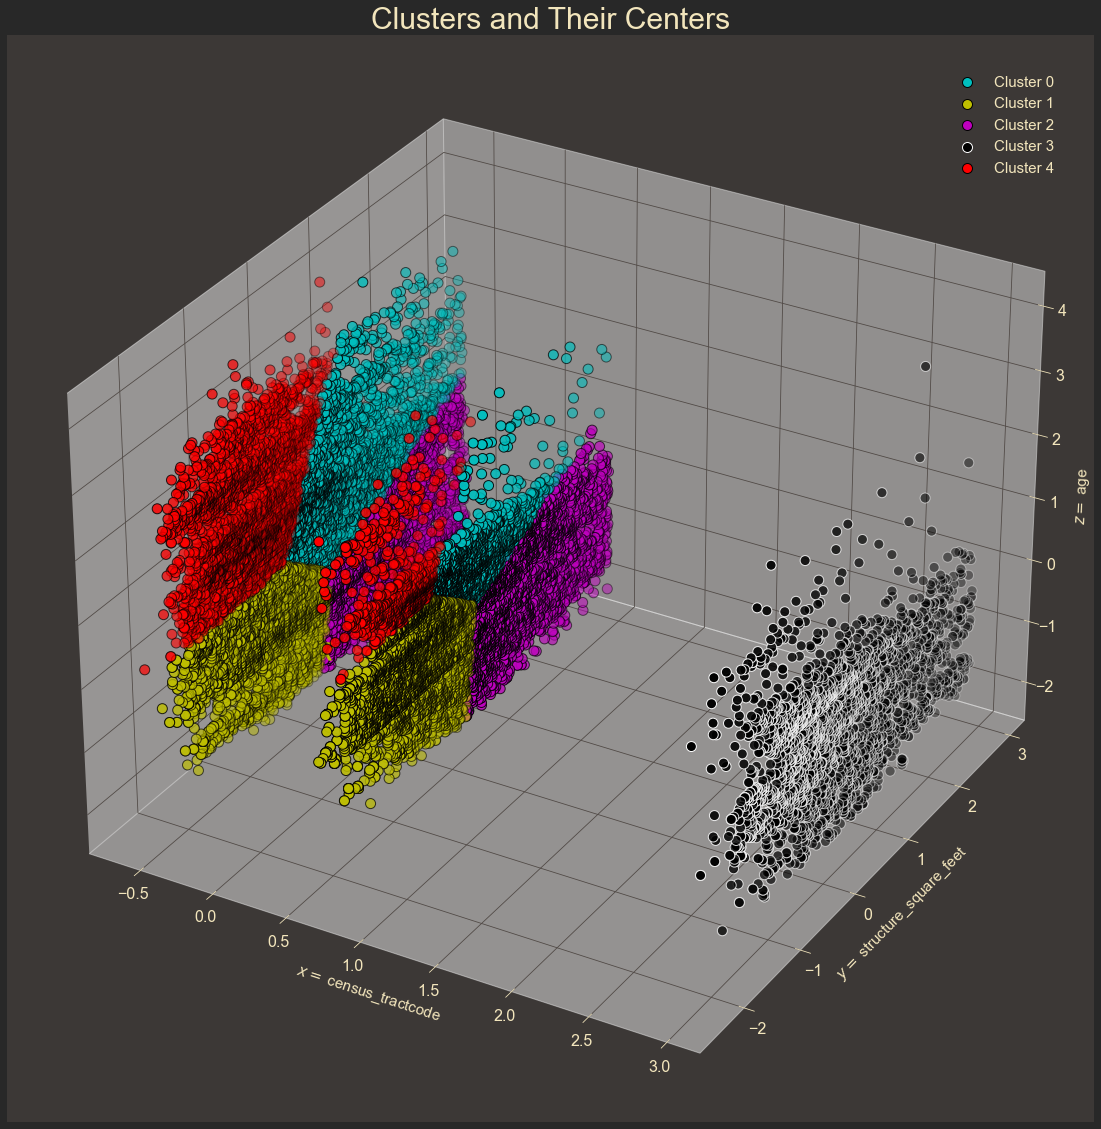

In [25]:
# create plot to view clusters for tract_size_age_clstr
explore.plot_three_d_clusters(cluster_df, center_df, 'census_tractcode', 'structure_square_feet', 'age')

### ❗ Key Findings

All of the clusters showed statistical significance in their log_error variance using the `f_oneway` function. The `tract_size_age_clstr` and `lot_rooms_clstr` groups had the highest F-statistics, which as it increases the p-value should get closer to zero. These two clusters may feature more prominently in modeling.

**Exploration Takeaways**

- The four variables showing strongest correlation to the target showed statistical significant in hypothesis testing:
    - ✓ `bedrooms`
        - Pearson $r \approx 0.02$
    - ✓ `structure_square_feet`
        - Pearson $r \approx 0.019$
    - ✓ `land_value_usd`
        - Pearson $r \approx 0.021$
    - ✓ `property_value_usd`
        - Pearson $r \approx 0.023$
    - Despite rejecting the null hypothesis for each, the correlation between the variables and the target is close to zero.
- The four cluster groups all showed statistically evident differences in `log_error` variance between populations.
    - ✓ `latitude` and `longitude`
        - $5$ clusters, $F$-$stat \approx3.55$
    - ✓ `lot_square_feet` and `room_count`
        - $5$ clusters, $F$-$stat \approx11.49$
    - ✓ `bedrooms_per_sqft` and `age`
        - $5$ clusters, $F$-$stat \approx4.14$
    - ✓ `census_tractcode`, `structure_square_feet`, and `bed_sqft_age`
        - $5$ clusters, $F$-$stat \approx7.18$
        
[[return to top](#%F0%9F%8F%98-Finding-Drivers-of-Zestimate-Errors)]

## 💠 Modeling and Evaluation
---
In order to find best performing models, recursive feature elimination (RFE) and `SelectKBest` were utilized to find recommended features. In this notebook, the best four performing models were brought in to demonstrate to process of creation, and of the twelve models created to finds drivers of `log_error`, these four all utilized feature engineering functions to select. For additinonal insight into this and remaining phases, please see the `modeling.ipynb` notebook.

### Scaling Data

Continuous variables were scaled prior to feature selection and modeling using the `StandardScaler` from `skelarn`. These scaled features were then joined onto the DataFrame and called by name in model fitting and prediction.

In [26]:
# set list of columns to be scaled and non-scaled
cols_to_scale = [
    'acreage',
    'age',
    'bathrooms',
    'bedrooms',
    'bedrooms_per_sqft',
    'full_bathrooms',
    'land_value_usd',
    'latitude',
    'longitude',
    'property_value_usd',
    'room_count',
    'structure_square_feet',
    'structure_value_usd',
    'tax_amount_usd']
unscaled_cols = [
    'bed_sqft_age_clstr_1',
    'bed_sqft_age_clstr_2',
    'bed_sqft_age_clstr_3',
    'bed_sqft_age_clstr_4',
    'census_tractcode',
    'la_county',
    'lat_long_clstr_1',
    'lat_long_clstr_2',
    'lat_long_clstr_3',
    'lat_long_clstr_4',
    'lot_rooms_clstr_1',
    'lot_rooms_clstr_2',
    'lot_rooms_clstr_3',
    'lot_rooms_clstr_4',
    'orange_county',
    'tract_size_age_clstr_1',
    'tract_size_age_clstr_2',
    'tract_size_age_clstr_3',
    'tract_size_age_clstr_4',
    'ventura_county']

In [27]:
for col in cols_to_scale:
    # create scaler object
    scaler = StandardScaler()
    # fit scaler object to train and transform
    X_train[f'{col}_scaled'] = scaler.fit_transform(X_train[[col]])
    # transform validate and test with train fit scaler
    X_validate[f'{col}_scaled'] = scaler.transform(X_validate[[col]])
    X_test[f'{col}_scaled'] = scaler.transform(X_test[[col]])

### Feature Selection

As previously describe, all four of the top performing models utilized automated feature selection from either RFE or `SelectKBest`. These column titles are assigned to a variable to be later called in model creation.

In [28]:
# create list to hold all feature names
all_features = X_train.filter(regex='scaled').columns.to_list() + unscaled_cols

- ***RFE Feature Selection***

In [29]:
# use RFE to find top 9 recommended features for modeling
top_n = explore.select_rfe(X_train[all_features], y_train.log_error, n=9)
print(f'\nThe top recommended features via RFE are:\n{top_n}.\n')


The top recommended features via RFE are:
['structure_value_usd_scaled', 'bed_sqft_age_clstr_2', 'bed_sqft_age_clstr_4', 'lat_long_clstr_2', 'lot_rooms_clstr_1', 'lot_rooms_clstr_2', 'lot_rooms_clstr_3', 'tract_size_age_clstr_2', 'tract_size_age_clstr_3'].



- ***KBest Feature Selection***

In [30]:
# use RFE to find top 9 recommended features for modeling
top_k = explore.select_kbest(X_train[all_features], y_train.log_error, k=9)
print(f'\nThe top recommended features via SelectKBest are:\n{top_k}.\n')


The top recommended features via SelectKBest are:
['bathrooms_scaled', 'bedrooms_scaled', 'full_bathrooms_scaled', 'room_count_scaled', 'structure_square_feet_scaled', 'lat_long_clstr_1', 'lot_rooms_clstr_1', 'tract_size_age_clstr_1', 'tract_size_age_clstr_2'].



### Modeling

#### Baseline Creation

Prior to attempting the creation of any model objects, a baseline must first be established as a metric for performance comparison. Two baselines are created here, using the mean and median of `log_error` from the `train` data set to be used in all comparisons. These baselines are stored into the DataFrames to be called upon later for comparison.

In [31]:
# create variable holding mean of log_error and attach to y
baseline_mean = y_train.log_error.mean()
y_train['baseline_mean'] = baseline_mean
y_validate['baseline_mean'] = baseline_mean
y_test['baseline_mean'] = baseline_mean

In [32]:
# create variable holding mean of log_error and attach to y
baseline_median = y_train.log_error.median()
y_train['baseline_median'] = baseline_median
y_validate['baseline_median'] = baseline_median
y_test['baseline_median'] = baseline_median

- ***Train***

    - Create DataFrames to hold mean and median baselines for future comparison on `train` performance.

In [33]:
# obtain mean baseline performance for model comparison on in-sample
rmse, r2 = model.get_metrics(y_train.log_error, y_train.baseline_mean)
model_dict = {'model':'baseline_mean', 'RMSE':rmse, 'R^2':r2}
insamp_df = pd.DataFrame([model_dict])

In [34]:
# obtain median baseline performance for model comparison on in-sample
rmse, r2 = model.get_metrics(y_train.log_error, y_train.baseline_median)
model_dict = {'model':'baseline_median', 'RMSE':rmse, 'R^2':r2}
insamp_df = insamp_df.append([model_dict], ignore_index=True)

- ***Validate***

    - Create DataFrames to hold mean and median baselines for future comparison on `validate` performance.

In [35]:
# obtain mean baseline performance for model comparison on out-of-sample
rmse, r2 = model.get_metrics(y_validate.log_error, y_validate.baseline_mean)
model_dict = {'model':'baseline_mean', 'RMSE':rmse, 'R^2':r2}
outsamp_df = pd.DataFrame([model_dict])

In [36]:
# obtain median baseline performance for model comparison on out-of-sample
rmse, r2 = model.get_metrics(y_validate.log_error, y_validate.baseline_median)
model_dict = {'model':'baseline_median', 'RMSE':rmse, 'R^2':r2}
outsamp_df = outsamp_df.append([model_dict], ignore_index=True)

- ***Test***

    - Create DataFrames to hold mean and median baselines for future comparison on `test` performance.

In [37]:
# obtain mean baseline performance for model comparison on test
rmse, r2 = model.get_metrics(y_test.log_error, y_test.baseline_mean)
model_dict = {'model':'baseline_mean', 'RMSE':rmse, 'R^2':r2}
test_df = pd.DataFrame([model_dict])

In [38]:
# obtain median baseline performance for model comparison on test
rmse, r2 = model.get_metrics(y_test.log_error, y_test.baseline_median)
model_dict = {'model':'baseline_median', 'RMSE':rmse, 'R^2':r2}
test_df = test_df.append([model_dict], ignore_index=True)

#### ⚙️ Ordinary Least Squared 1

- Uses the standard OLS algorithm along with the top nine RFE recommended features. This model out performed both baselines on `train` data.

In [39]:
# using top five according to RFE on train

# create model object
lm1 = LinearRegression(normalize=True)
# run train_model function to fit model to train and obtain performance metrics
y_train['lm1_predictions'], model_dict = model.train_model(X_train[top_n], y_train.log_error, lm1, 'lm1')
# append performance metrics to dataframe
insamp_df = insamp_df.append([model_dict], ignore_index=True)

In [40]:
# show current model performance on train
# pull DataFrame with Baseline and specific models for comparison
insamp_df[insamp_df.model.str.contains('base') | \
insamp_df.model.str.contains('lm1')].sort_values('RMSE')

,model,RMSE,R^2
2,lm1,0.156488,0.002863
0,baseline_mean,0.156712,0.000000
1,baseline_median,0.157023,0.000000


- ***Set Validate Predictions***

In [41]:
# run model_testing function to evaluate performance using out-of-sample data set
y_validate['lm1_predictions'], model_dict = model.model_testing(X_validate[top_n], y_validate.log_error, lm1, 'lm1')
# append performance metrics to dataframe
outsamp_df = outsamp_df.append([model_dict], ignore_index=True)

#### ⚙️  Ordinary Least Squared 2

- Uses the standard OLS algorithm along with the top nine `SelectKBest` recommended features. This model out performed both baselines on `train` data.

In [42]:
# using top five according to SelectKBest on train

# create model object
lm2 = LinearRegression(normalize=True)
# run train_model function to fit model to train and obtain performance metrics
y_train['lm2_predictions'], model_dict = model.train_model(X_train[top_k], y_train.log_error, lm2, 'lm2')
# append performance metrics to dataframe
insamp_df = insamp_df.append([model_dict], ignore_index=True)

In [43]:
# show current model performance on train
# pull DataFrame with Baseline and specific models for comparison
insamp_df[insamp_df.model.str.contains('base') | \
insamp_df.model.str.contains('lm2')].sort_values('RMSE')

,model,RMSE,R^2
3,lm2,0.156606,0.001362
0,baseline_mean,0.156712,0.000000
1,baseline_median,0.157023,0.000000


- ***Set Validate Predictions***

In [44]:
# run model_testing function to evaluate performance using out-of-sample data set
y_validate['lm2_predictions'], model_dict = model.model_testing(X_validate[top_k], y_validate.log_error, lm2, 'lm2 ')
# append performance metrics to dataframe
outsamp_df = outsamp_df.append([model_dict], ignore_index=True)

#### ⚙️ Generalized Linear Model 1

- Uses the GLM algorithm for normal distribution along with the top nine RFE recommended features. This model out performed both baselines on `train` data.

In [45]:
# using top five according to RFE on train

# create model object
glm1 = TweedieRegressor()
# run train_model function to fit model to train and obtain performance metrics
y_train['glm1_predictions'], model_dict = model.train_model(X_train[top_n], y_train.log_error, glm1, 'glm1')
# append performance metrics to dataframe
insamp_df = insamp_df.append([model_dict], ignore_index=True)

In [46]:
# show current model performance on train
# pull DataFrame with Baseline and specific models for comparison
insamp_df[insamp_df.model.str.contains('base') | \
insamp_df.model.str.contains('glm1')].sort_values('RMSE')

,model,RMSE,R^2
4,glm1,0.156668,0.000566
0,baseline_mean,0.156712,0.000000
1,baseline_median,0.157023,0.000000


- ***Set Validate Predictions***

In [47]:
# run model_testing function to evaluate performance using out-of-sample data set
y_validate['glm1_predictions'], model_dict = model.model_testing(X_validate[top_n], y_validate.log_error, glm1, 'glm1')
# append performance metrics to dataframe
outsamp_df = outsamp_df.append([model_dict], ignore_index=True)

#### ⚙️ Generalized Linear Model 2

- Uses the GLM algorithm for normal distribution along with the top nine `SelectKBest` recommended features. This model out performed both baselines on `train` data.

In [48]:
# using top five according to SelectKBest on train

# create model object
glm2 = TweedieRegressor()
# run train_model function to fit model to train and obtain performance metrics
y_train['glm2_predictions'], model_dict = model.train_model(X_train[top_k], y_train.log_error, glm2, 'glm2')
# append performance metrics to dataframe
insamp_df = insamp_df.append([model_dict], ignore_index=True)

In [49]:
# show current model performance on train
# pull DataFrame with Baseline and specific models for comparison
insamp_df[insamp_df.model.str.contains('base') | \
insamp_df.model.str.contains('glm2')].sort_values('RMSE')

,model,RMSE,R^2
5,glm2,0.156634,0.000995
0,baseline_mean,0.156712,0.000000
1,baseline_median,0.157023,0.000000


- ***Set Validate Predictions***

In [50]:
# run model_testing function to evaluate performance using out-of-sample data set
y_validate['glm2_predictions'], model_dict = model.model_testing(X_validate[top_k], y_validate.log_error, glm2, 'glm2')
# append performance metrics to dataframe
outsamp_df = outsamp_df.append([model_dict], ignore_index=True)

### Out-of-Sample Evaluation

Having seen the performance on the in-sample data, now is the time to evaluate it on the `validate` data set. Using the same baseline mean and median as a comparison, the best performing model of this evaluation will be carried on to the final `test` data.

In [51]:
# output performance sorting for RMSE of models on out-of-sample validate
outsamp_df.sort_values('RMSE')

,model,RMSE,R^2
2,lm1,0.164097,0.000933
3,lm2,0.164126,0.000585
5,glm2,0.164140,0.000399
4,glm1,0.164147,0.000327
0,baseline_mean,0.164173,0.000000
1,baseline_median,0.164441,0.000000


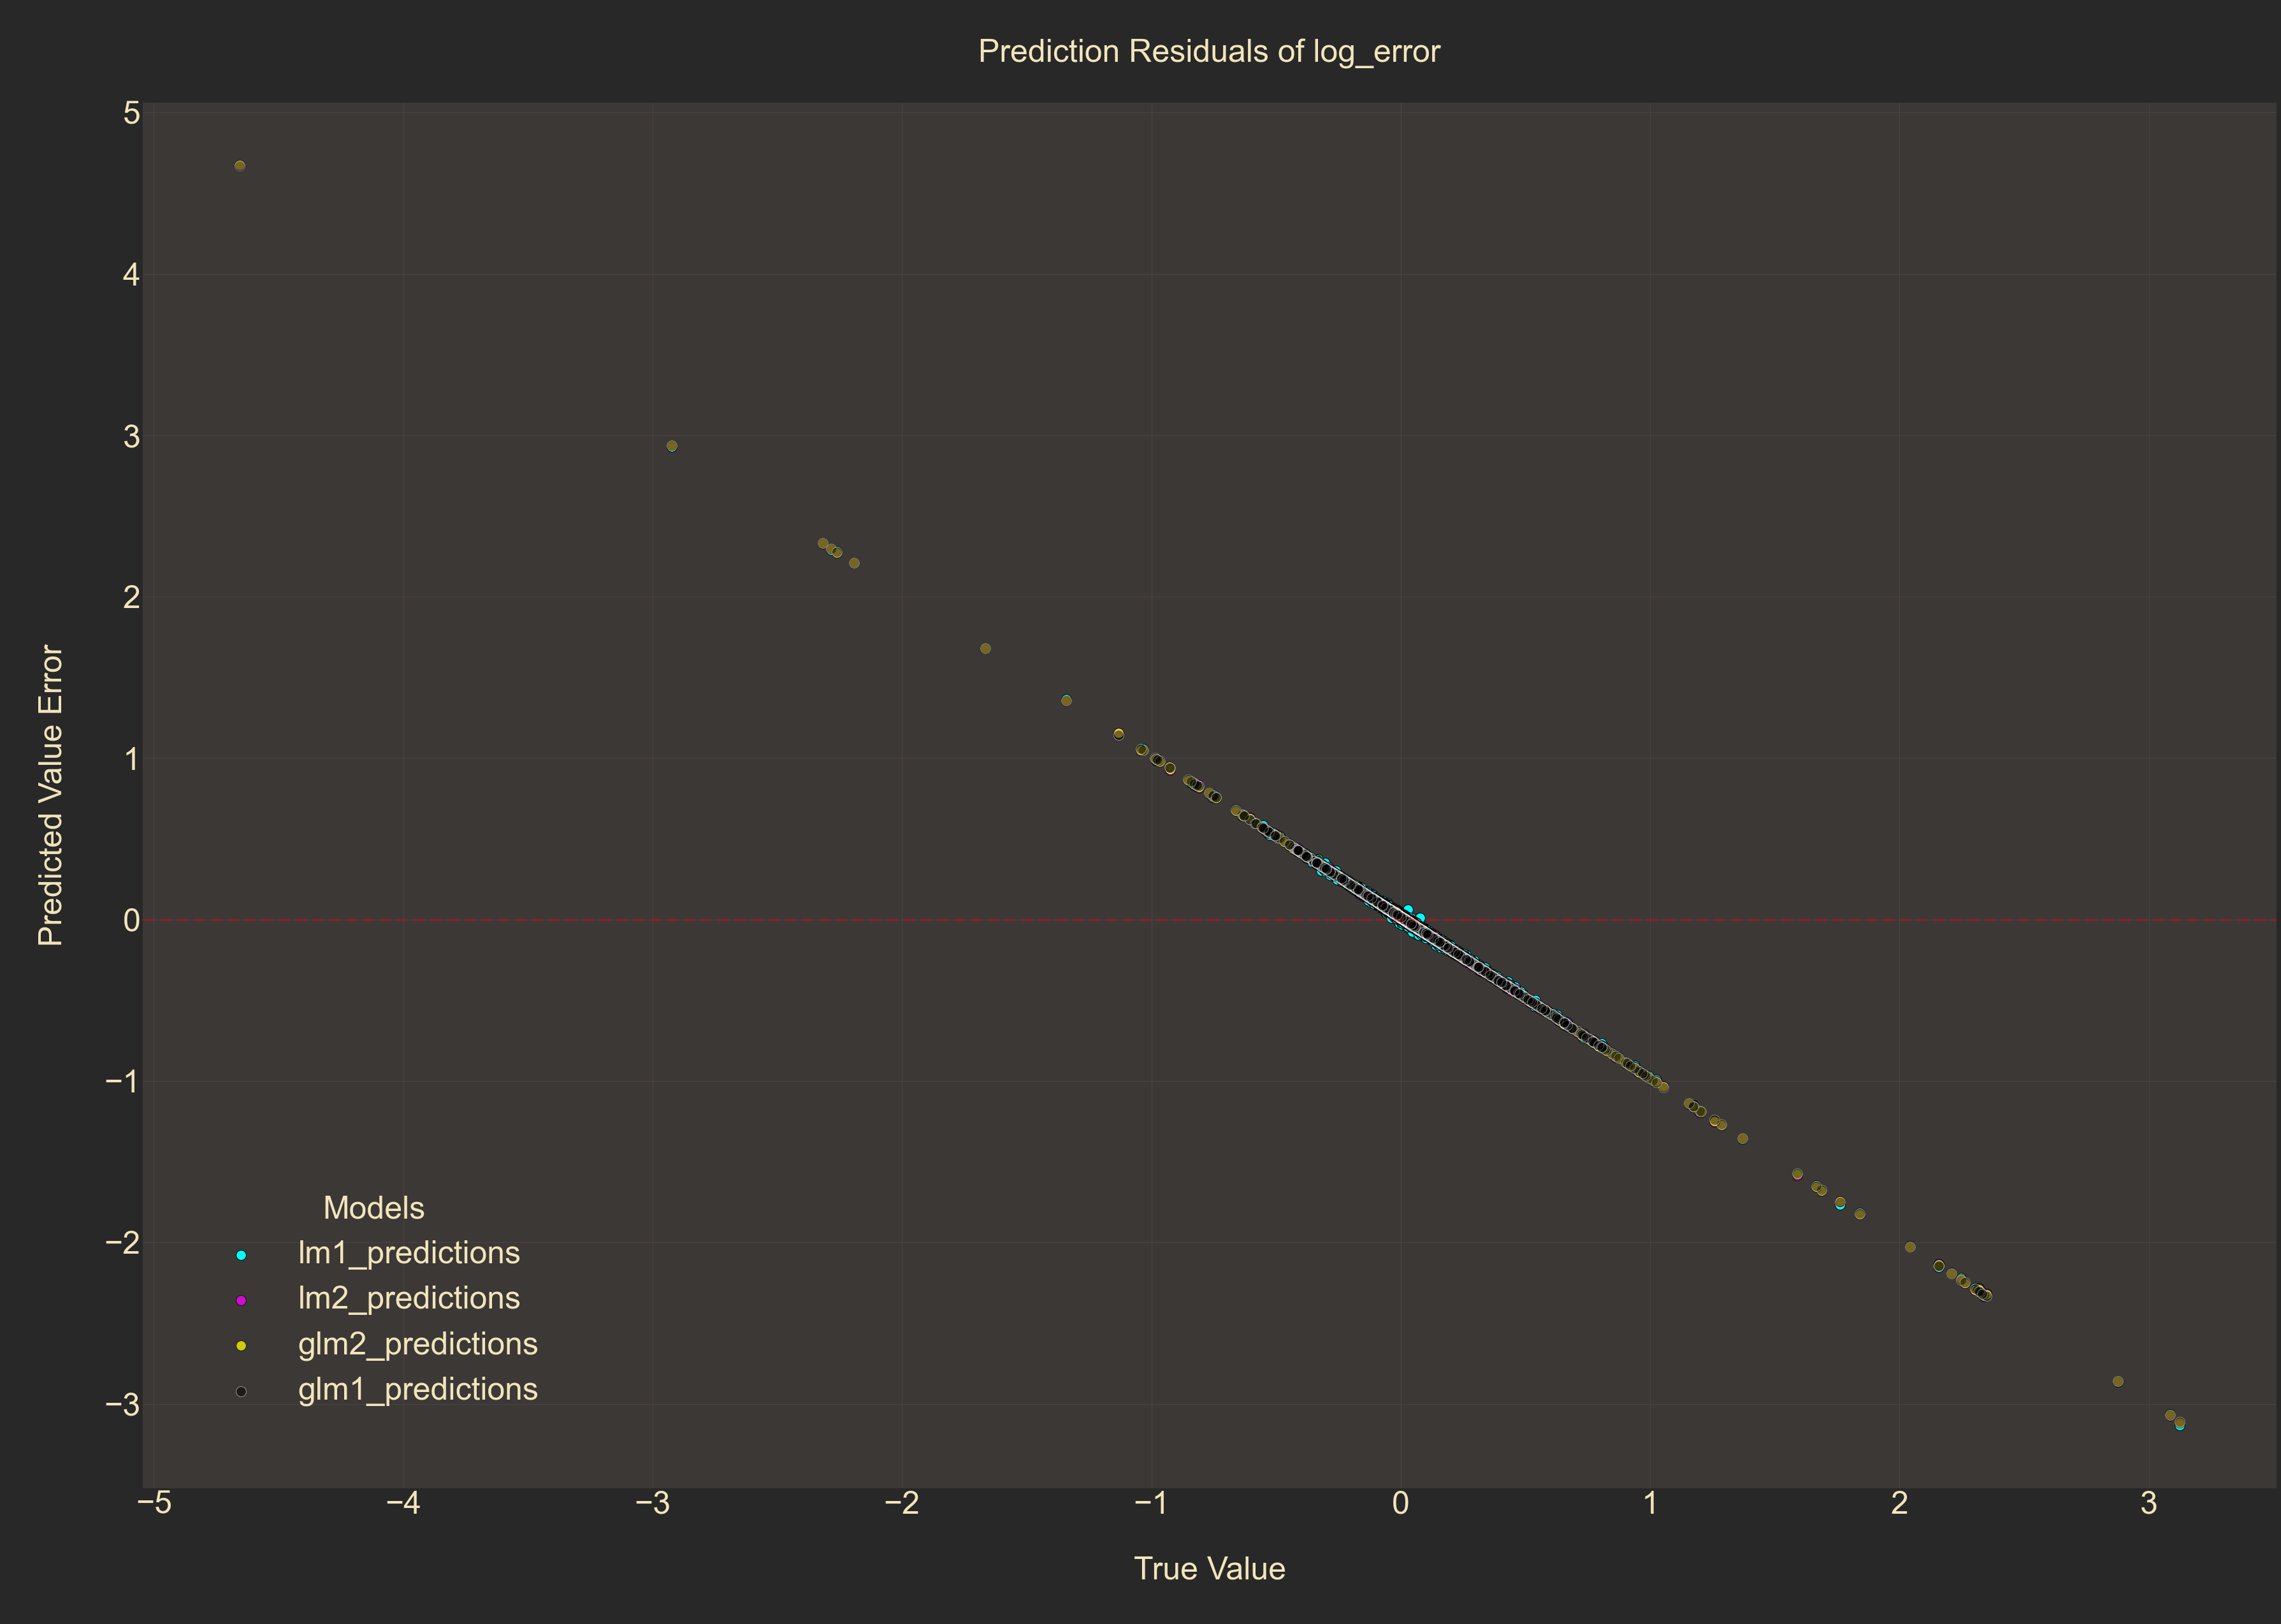

In [52]:
# plot residuals of top four models on out-of-sample validate
y_val_preds = y_validate[['lm1_predictions', 'lm2_predictions', 'glm2_predictions', 'glm1_predictions']]
y_val_true = y_validate.log_error
model.plot_residuals(y_val_true, y_val_preds)

### ❗ Modeling Report

Of the four models shown in this final report, all four of them out performed the baselines on the `train` and `validate` data. They all used recommended features via RFE or `SelectKBest`, and all four of them out performed the other eight models created in the `modeling.ipynb` notebook. Despite this, the best improvement over the baseline mean on `validate` was the `lm1` model, which was a rather low $\approx0.14\%$ change in RMSE. Looking at the plot of residuals, there is a definitive negative trend from predicting higher log_error and lower true values to predicting increasingly lower values as true value increases. Even if this performance carries into the model testing, it is unlikely this will bear any particularly strong insights.

**Key Takeaways**

- Mean Baseline RMSE was $0.164173$ on `validate`
- Features selected with `rfe` and `SelectKBest` performed consistently better on all models and on in-sample and out-of-sample data than manually selected features
- `rfe` largely recommended cluster created features, while `SelectKBest` recommended mostly features found within the initial data
- All models had consistent performance across data sets, suggesting over fitting did not occur on the training
- `lm1` was the top performing algorithm with RMSE of $0.164097$ on `test`
- Despite a lower RMSE than the baselines, model `lm1` RMSE was only $\approx0.05\%$ lower than mean baseline on `validate`

[[return to top](#%F0%9F%8F%98-Finding-Drivers-of-Zestimate-Errors)]

## 💠 Final Test
---

In [53]:
# run model_testing function to evaluate performance using test data set
y_test['lm1_predictions'], model_dict = \
            model.model_testing(X_test[top_n], y_test.log_error, lm1, 'lm1')
# append performance metrics to dataframe
test_df = test_df.append([model_dict], ignore_index=True)

In [54]:
# compare baseline and model performance on test
test_df.sort_values('RMSE')

,model,RMSE,R^2
2,lm1,0.148260,0.00177
0,baseline_mean,0.148391,0.00000
1,baseline_median,0.148637,0.00000


- ***Residuals Plot***

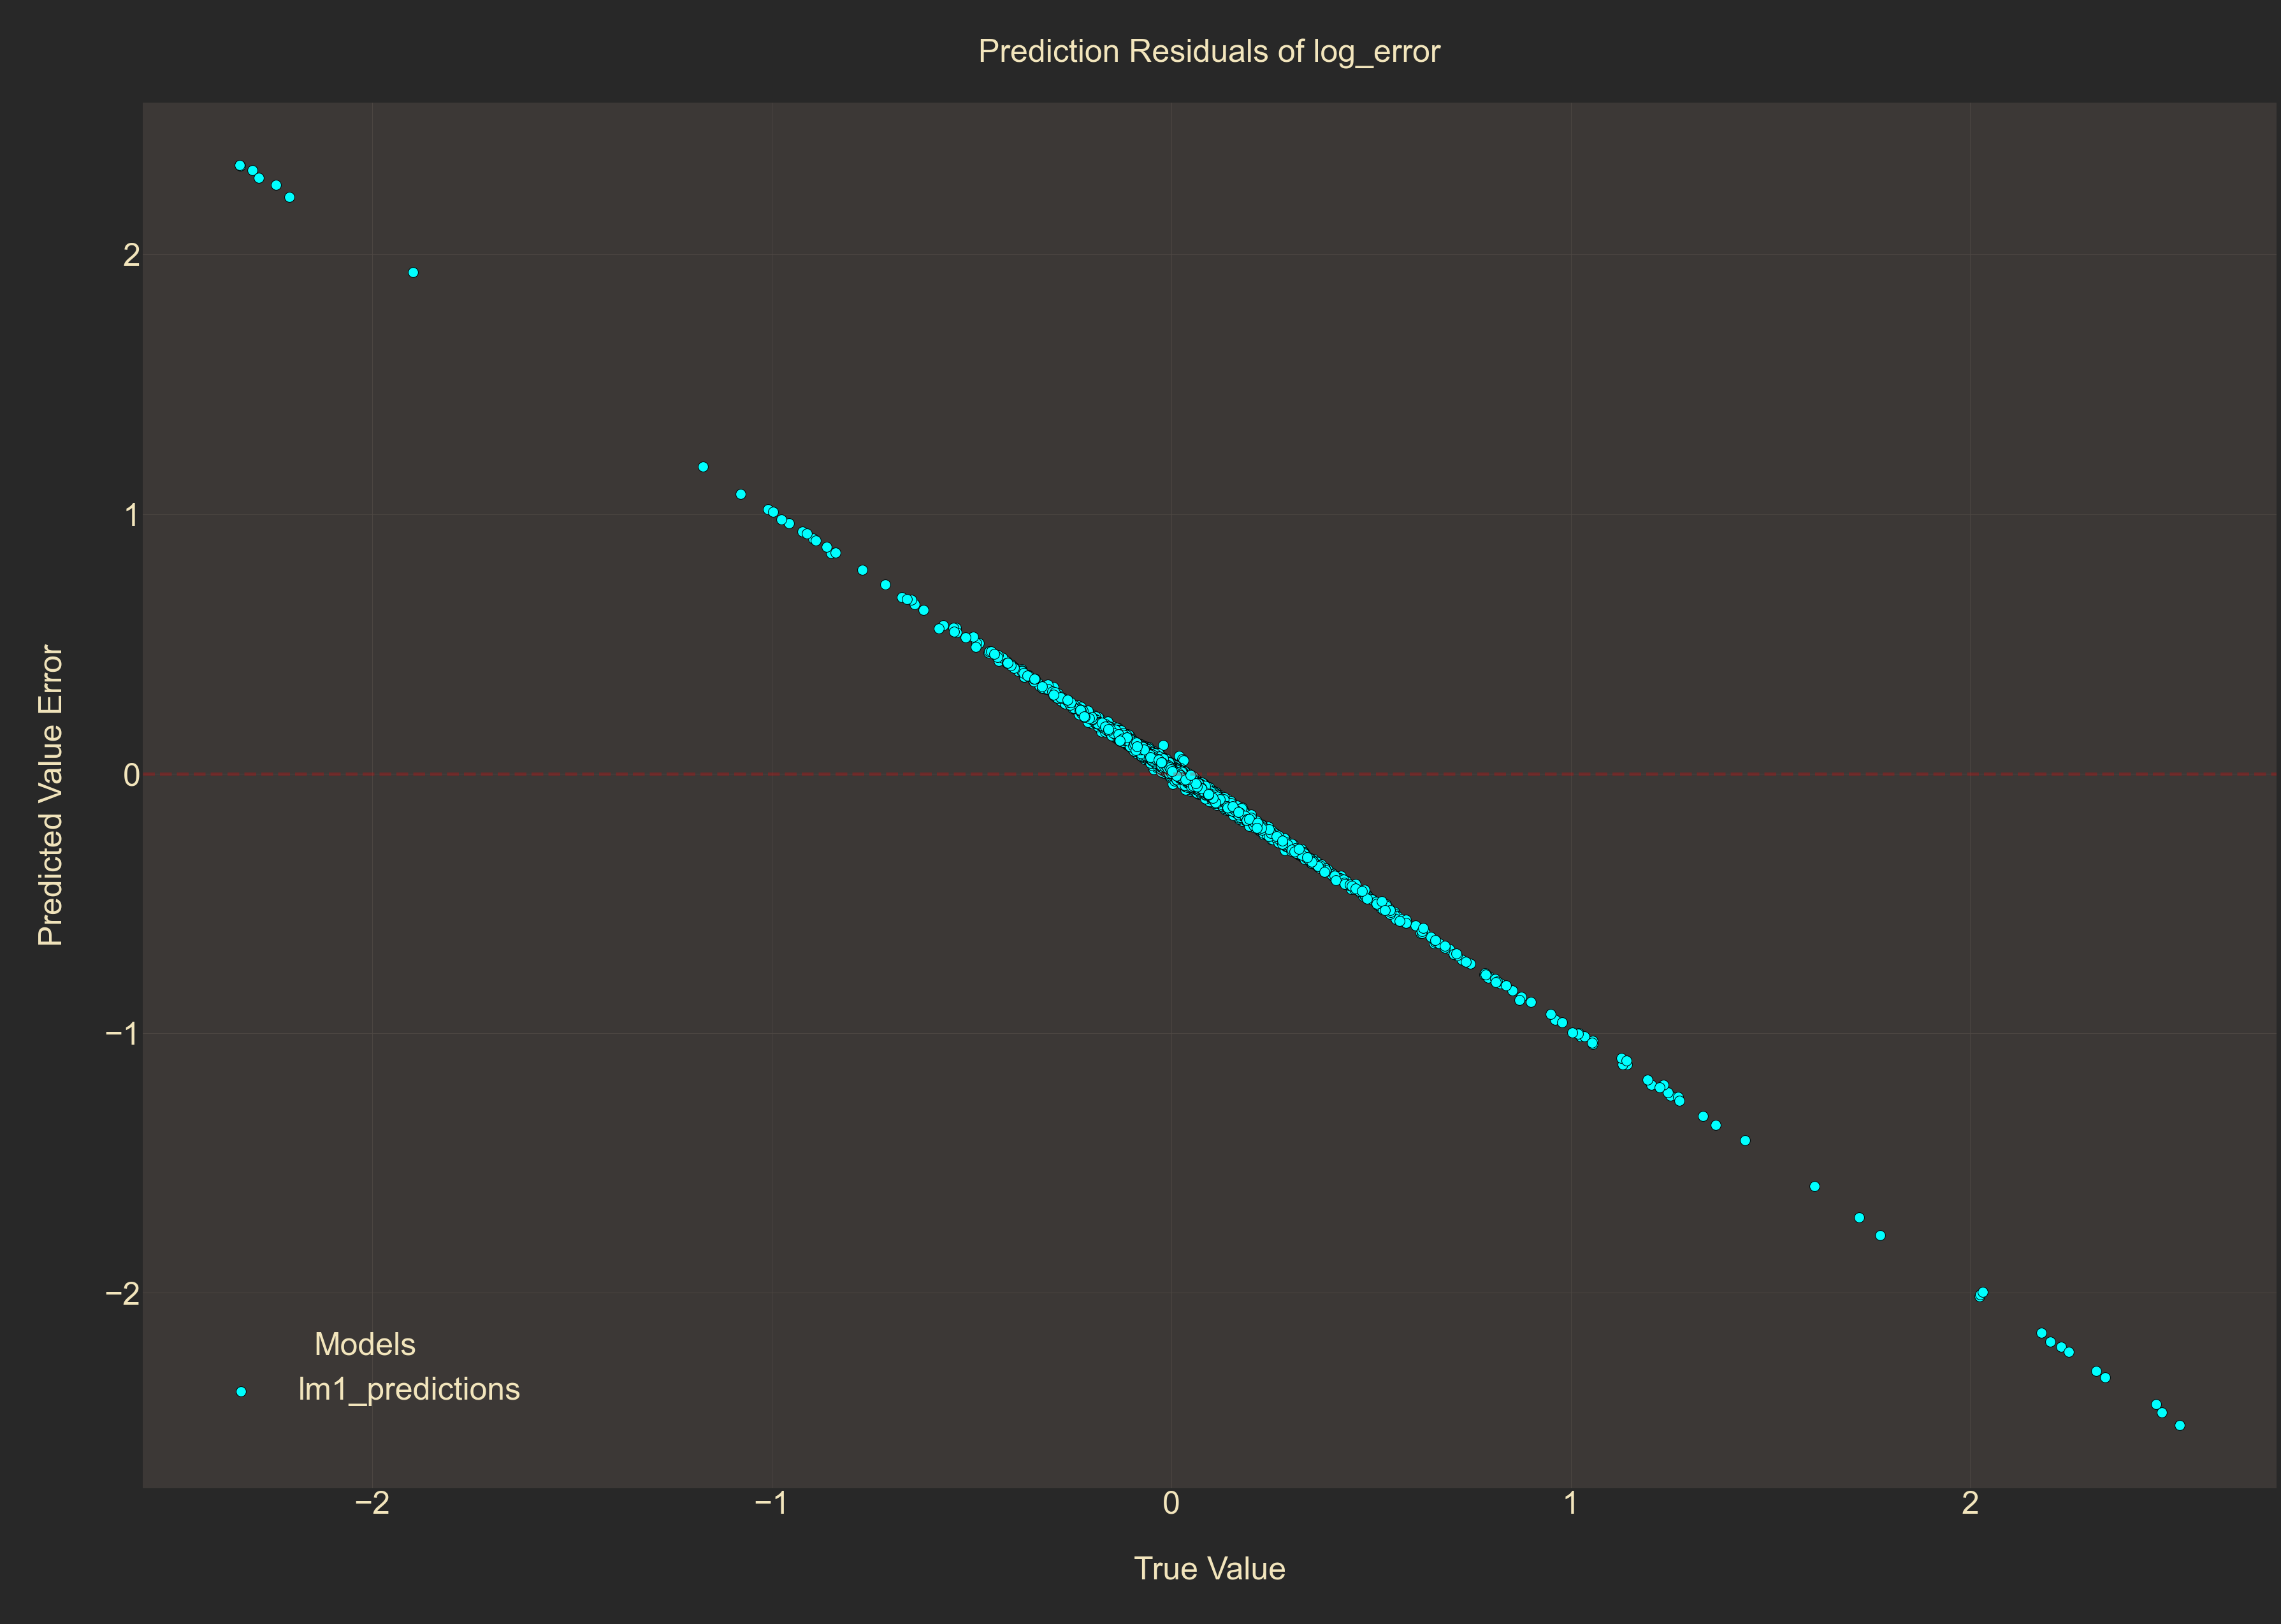

In [55]:
# plot residuals of model on test
model.plot_residuals(y_test.log_error, y_test[['lm1_predictions']])

- ***Target Prediction and Actual Distribution Plot***

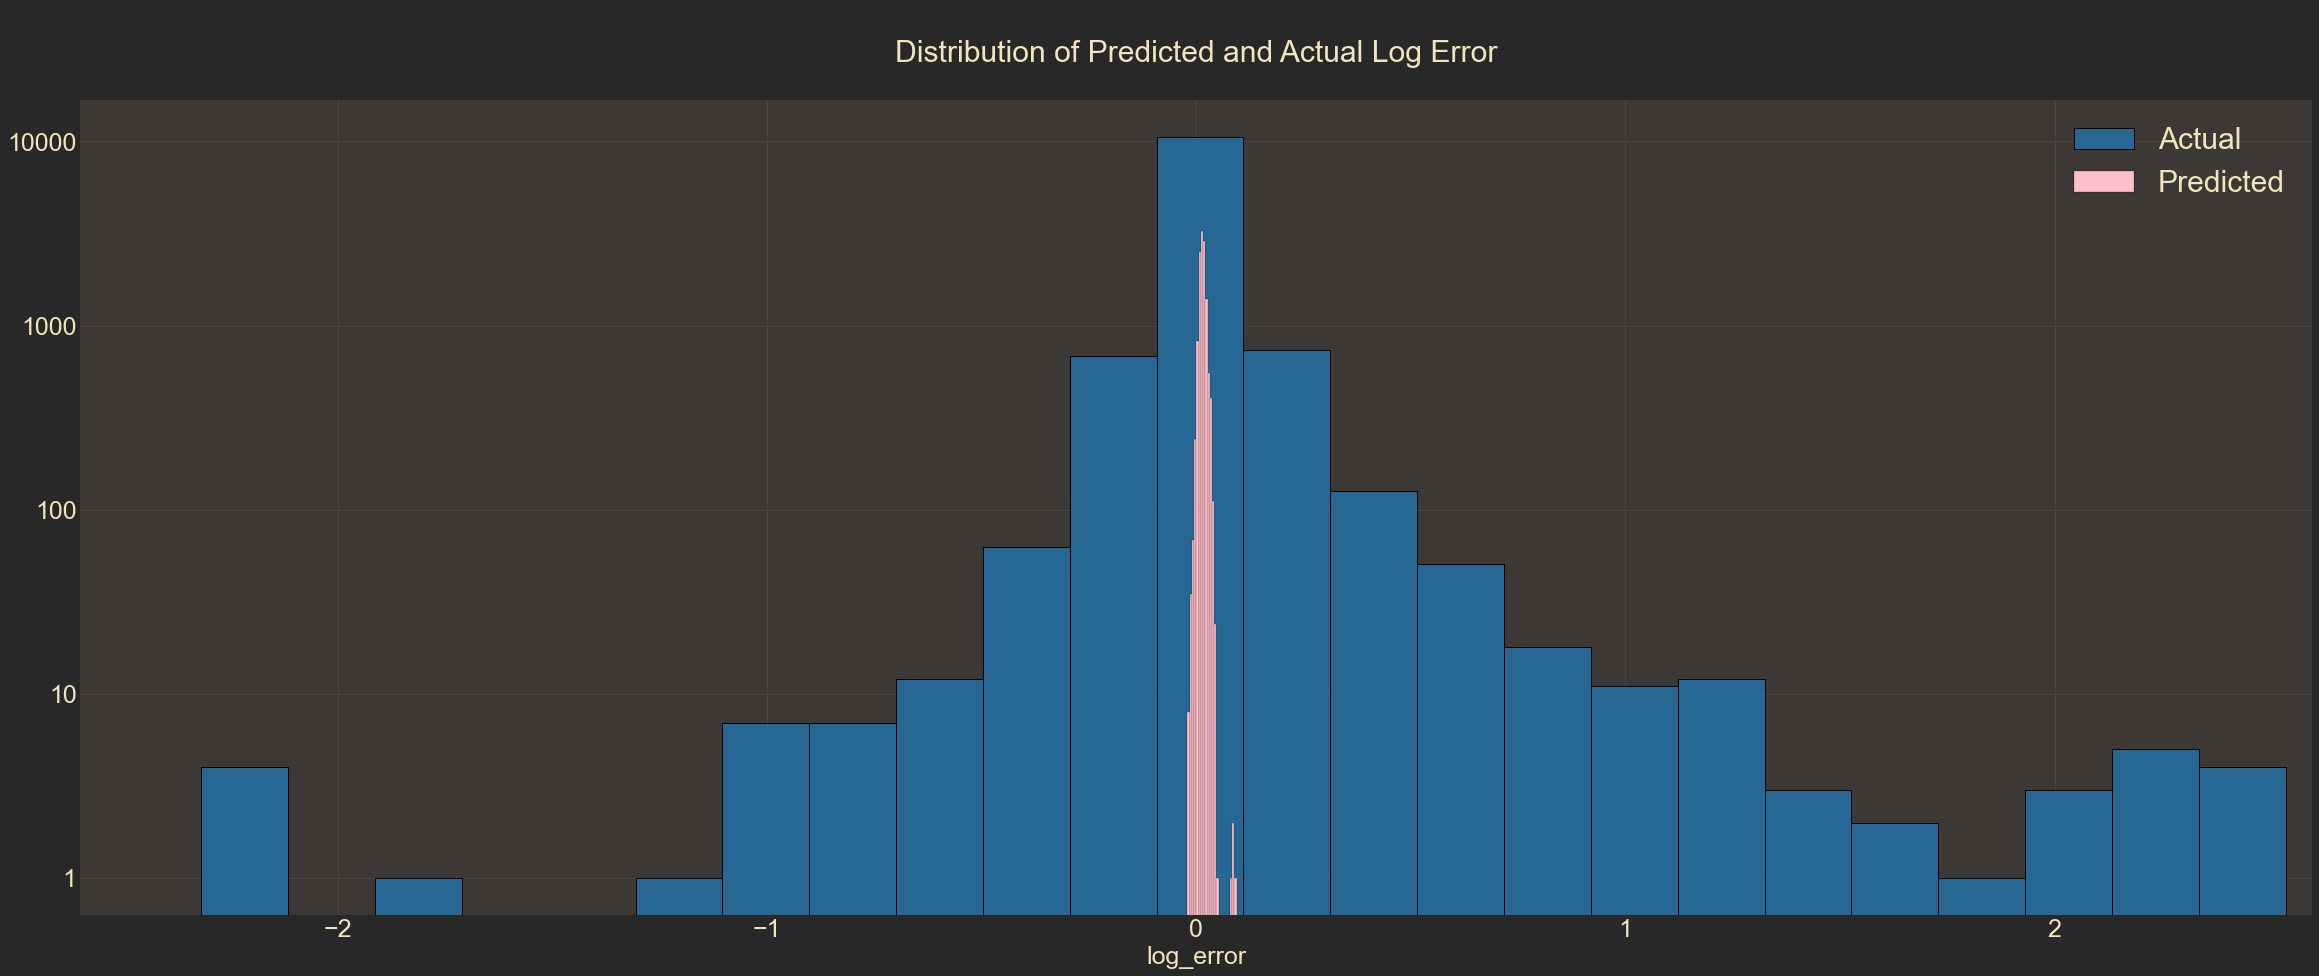

In [56]:
# plot prediction and actual distributions
plt.figure(figsize=(40, 15))
# set bins using min, mean, and max of actual values
bins1 = np.linspace(-2.33172653205, 0.0142533962575622464, 25)
bins2 = np.linspace(0.0142533962575622465, 2.52399218129, 25)
bins = bins1 + bins2
sns.histplot(y_test.log_error, bins=bins, label='Actual')
# set bins using min, mean, and max of values in predictions
bins1 = np.linspace(-0.03555942199743989, 0.0155444512995399324, 25)
bins2 = np.linspace(0.0155444512995399325, 0.0890508308087443, 25)
bins = bins1 + bins2
sns.histplot(y_test.lm1_predictions, bins=bins, color='pink', alpha=1, label='Predicted')
# set display settings
plt.xlim(-2.6, 2.6)
plt.xticks(fontsize=25)
plt.xlabel('log_error',fontsize=25)
plt.yscale('log')
plt.yticks(ticks=[1, 10, 100, 1000, 10000], labels=[1, 10, 100, 1000, 10000], fontsize=25)
plt.ylabel('')
plt.title('\nDistribution of Predicted and Actual Log Error\n', fontsize=30)
plt.legend(fontsize=30)
# show plot
plt.show()

### 🔥 Final Test Takeaways

- Mean Baseline RMSE was $0.148391$ on `test`
- `LinearRegression(normalize=True)` was the top performing algorithm with a final RMSE of $0.148260$ on `test`
    - This model made use of the top nine `rfe` recommended features:
        - `structure_value_usd`
        - `bed_sqft_age_clstr_2`
        - `bed_sqft_age_clstr_4`
        - `lat_long_clstr_2`
        - `lot_rooms_clstr_1`
        - `lot_rooms_clstr_2`
        - `lot_rooms_clstr_3`
        - `tract_size_age_clstr_2`
        - `tract_size_age_clstr_3`
    - All but one of the recommended features were clusters created in exploration
- Despite a lower RMSE than the baselines, model `lm1` RMSE was only $\approx0.09\%$ lower than mean baseline on `test`
- The plotted distribution makes a clear case that the algorithm fit to the train data all but refused to deviate more than one-tenth of a point from zero
    - The pink sliver of predictions within the middle bin of actual values is $50$ bins with the same number of values as the blue bars
    
[[return to top](#%F0%9F%8F%98-Finding-Drivers-of-Zestimate-Errors)]

<br><br>
<img src='https://raw.githubusercontent.com/ray-zapata/project_clustering_zillow/main/assets/divider.png'>
<br><br><br>

## 💠 Report Summary
---
In this report it was demonstrated how the data was acquired and prepared in a manner to keep the maximum amount of observations for exploration of relationships to use in cluster formations to create models and find drivers of `log_error` in the Zillow® Zestimate. Despite finding statistically evident relationships between initially obtained variables and the target, they proved to be too weak to be strong drivers or provide sufficient insights.

- `bedrooms`, `room_count`, `structure_square_feet`, and `property_value_usd`
    - Correlations were found to be statistically evident using Pearson $r$ correlation test with $\alpha$ of $0.05$
    - All correlations had nearly zero coefficient for all variables toward target, flat line in regression plots
- `bed_sqft_age`, `lat_long`, `lot_rooms`, and `tract_size_age` cluster groups
    - Clustered populations were found to have statistically significant variances in `log_error` using `f_oneway` test with $\alpha$ of $0.05$
    - All four clusters had certain population boolean features selected by RFE for modeling
    
Using these takeaways, several linear regression models were created in order to predict `log_error` and find the strongest drivers with the appropriate algorithm. Of these models, using the RFE selected features listed above, an ordinary least squared model was found to be the best performer and put to test against the $20\%$ out-of-sample, unseen data.

- `lm1` model had RMSE of $0.164097$ on `validate` and $0.148260$ on `test`
    - This model performed better than both baselines in all phases of testing
    - Model performance on test was $\approx0.09\%$ lower RMSE than the baseline mean
    
To summarize it into a simple statement: despite being successful, it is so trivial that no true insights can be gleaned from its results.

### Further Steps

As stated in the introduction to this report, with more time it is thought that using more precise location data could yield the identity of drivers in the `log_error`. Using geocoding to segment property location into sociogeographic locations using zip codes, neighborhoods, and street blocks could potential may prove useful with more time and resources. It is also possible that by dividing the project in two and discern drivers that lead to under-estimating versus over-estimating could provide further penetration into any findings.

It is also recommended in future pursuits of this nature that the method of creating the `log_error` become more transparent. It is unlikely that is is the common decimal logarithm, and further exploration towards the target would be complimented by being able to transform it as desired.

[[return to top](#%F0%9F%8F%98-Finding-Drivers-of-Zestimate-Errors)]

In [57]:
end()


































 

































 

































 

































 

































 Open your eyes and see what you can with them before they close forever.
